# Classification : Heart failure clinical records dataset


## Introduction 
Cardiovascular diseases kill several people every year, and they mainly exhibit myocardial infarctions and heart failures. For doctors is crucial to understand how severe is the cardiovascular disease of a patient. The patients can be analyzed in terms of electronic medical records which quantify symptoms, body features, and clinical laboratory test values. There are some well-known risk factors, such as *serum creatinine* and *ejection fraction*, that are a key flag for detecting cardiovascular diseases. However, in some situations, the whole figure of a patient may be not clear and the risk factors could not be enough for detecting the disease. 

With Machine Learning we can derive non-trivial decision rules that can predict whenever the patients are at risk of death given in medical records. Moreover, models like *Decision Tree* or *Random Forest* can individuate the most important features among the ones included in the records. In this work, we deal with a medical dataset, where there are contained a lot of clinical measurement of patients observed during a follow-up period together with a variable that declare the state of the patient at the end of the period, which can be *survived* or *death*. We apply several classification algorithms to this dataset obtaining models that learn how to predict the risk of death for a patient given input medical record.

The work is dived into $4$ sections:
- **Exploratory Data Analysis** : where we understand what kind of data we have;
- **Preprocessing** : where we manipulate the data making them more proper for classification algorithms;
- **Model Selection and hyperparameter tuning** : where we define the models and detect the best configurations of the hyperparameters; 
- **Model evaluation** : where we evaluate the selected classification models on unseen data.

The dataset is available at the link : [dataset.](http://archive.ics.uci.edu/ml/machine-learning-databases/00519/)

In [1]:
! pip install imblearn

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style("whitegrid")

# SEEDS for reproducing the results
SEED_TRAIN_TEST_SPLIT = 88
SEED_TRAIN_VALID_SPLIT = 145
SEED_SMOTE = 310
global SEED_HP_TUNING
SEED_HP_TUNING = 55
SEED_HP_TUNING_THRESHOLD = 12345
SEED_TEST_CV = 2
SEED_MODEL_STATE = 77

## Dataset Description
The dataset contains the medical records of $299$ heart failure patients. We have $13$ features, namely:
- *age* : the age of the patient;
- *anaemia* : a binary variable that shows if the patient is anemic or not, encoded respectively with $1$ and $0$;
- *creatinine_phosphokinase* : the level of the homonym enzyme in the blood;
- *diabetes* : a binary variable that shows if the patient is diabetic or not, encoded respectively with $1$ and $0$;
- *ejection_fraction* : the proportion of blood pumped out of the hearth during a single contraction;
- *high_blood_pressure* : a binary variable that shows if the patient suffers from hight blood pressure or not, encoded respectively with $1$ and $0$;
- *platelets* : the measure of blood platelets;
- *serum_creatinine* : the level of serum creatine in the blood; 
- *serum_sodium* : the level of serum sodium in the blood;
- *sex* : a binary variable that indicates if the patient is a male or a female, encoded respectively with $1$ and $0$;
- *smoking* : a binary variable that indicates if the patient is a smoker or not, encoded respectively with $1$ and $0$;
- *time* : the length of the follow-up period;
- *DEATH_EVENT* : the binary response variable that indicates if the patient survives or not before the end of the follow-up period, $0$ if the patient survives, and $1$ otherwise. 

Now we read the dataset and then we proceed with the analysis of the features.

In [3]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
print(f"Shape of the dataset : {df.shape}")
df.head()

Shape of the dataset : (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


The dataset has no missing values, as the following output conferms.

In [4]:
np.sum(df.isna())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Next, we look at the response variable and we see that only $203$ patients survive. So, the dataset is slightly unbalanced: around $32.11 \%$ of the patients belong to class $1$ (the death event occurs), and the remaining $67.89 \%$ are in class $0$ (they survive).

In [5]:
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

We can see that we have $5$ binary features (without considering the response variable) : *anaemia*, *diabetes*, *high_blood_pressure*, *sex*, and *smoking*. We report descriptive analysis of those.

In [6]:
names = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

print(f"'anaemia' : {df['anaemia'].value_counts()[1]} are aneamic and {df['anaemia'].value_counts()[0]} are not") 
print(f"'diabetes' : {df['diabetes'].value_counts()[1]} are diabetic and {df['diabetes'].value_counts()[0]} are not") 
print(f"'high_blood_pressure' : {df['high_blood_pressure'].value_counts()[1]} suffer from hight blood pressure and {df['high_blood_pressure'].value_counts()[0]} do not") 
print(f"'sex' : {df['diabetes'].value_counts()[1]} are male and {df['diabetes'].value_counts()[0]} are female") 
print(f"'smoking' : {df['smoking'].value_counts()[1]} are smokers and {df['smoking'].value_counts()[0]} are not") 

'anaemia' : 129 are aneamic and 170 are not
'diabetes' : 125 are diabetic and 174 are not
'high_blood_pressure' : 105 suffer from hight blood pressure and 194 do not
'sex' : 125 are male and 174 are female
'smoking' : 96 are smokers and 203 are not


We detect that the proportion of smokers are the same of the ones of the response variable, this fact rises the possibility of a perfect correlation between the two variable. So, we count the number of observations for each pair of levels of the variables.

In [7]:
pd.pivot_table(df, values = None, index = ['DEATH_EVENT'], columns = ['smoking'], aggfunc = len)['age']

smoking,0,1
DEATH_EVENT,,
0,137.0,66.0
1,66.0,30.0


We can see that only $30$ of the $96$ smokers are dead before the end of the follow-up period, so there is no perfect correlation between the variable.

The remaining $7$ features are numerical, we present summary statistics of them:

In [8]:
df.loc[:, ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']].describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


We can see that patients' ages range from $40$ to $95$ with an average of $60$ years. While, the follow-up period ranged from a minimum of $4$ days to a maximum of $285$, with an average of $130$ days. The $5$ features in the middle take very different values from each other, moreover, they are evaluated with a different unit of measure. For example, the *serum creatinine* is in the order of the unit while *plateles* is in the order of $10^5$. This huge difference between the magnitude of the numerical features may be a problem for machine learning models, so we will manage this in the preprocessing phase. 

## Exploratory Data Analysis
In the first view, we can analyze the correlation matrix of the dataset. We can see that there are no strong correlations, but interestingly we find that the response variable is moderately positively correlated with *age* and *serum_creatinine* while it is moderately negatively correlated with *ejection_fraction*, *serum_sodium* and *time*.

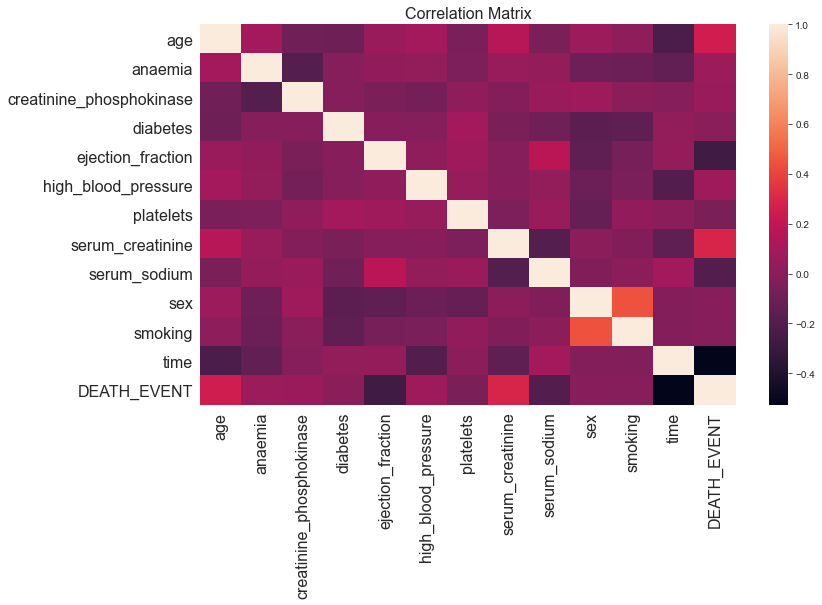

In [9]:
fig, ax = plt.subplots(figsize = [12,7])
ax = sns.heatmap(df.corr())
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
    
ax.set_title('Correlation Matrix', fontsize = 16)
plt.show()

The negative correlation with *time* is far from being unexpected, in fact, one of the reasons for the termination of the follow-up period is the death of the patient. Indeed, the following histogram shows that the distribution of time is strongly biased toward relatively small follow-up periods. Moreover, differently from the other variables, it can be measured only at the end of the period of observation so it cannot be considered for prediction. For that reason, we remove the variable from the analysis. 

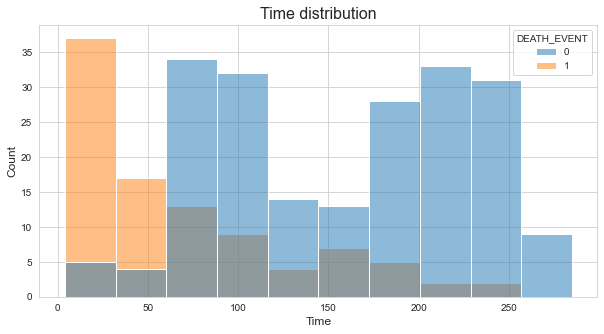

In [10]:
fig, ax = plt.subplots(figsize=[10,5])
sns.histplot(data=df, x='time', hue='DEATH_EVENT', ax =ax)
ax.set_title('Time distribution', fontsize = 16)
ax.set_xlabel('Time', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12)
plt.show()

At first glance, we can conclude nothing from the exploration of the binary features: none of the variables separates clearly the class labels.

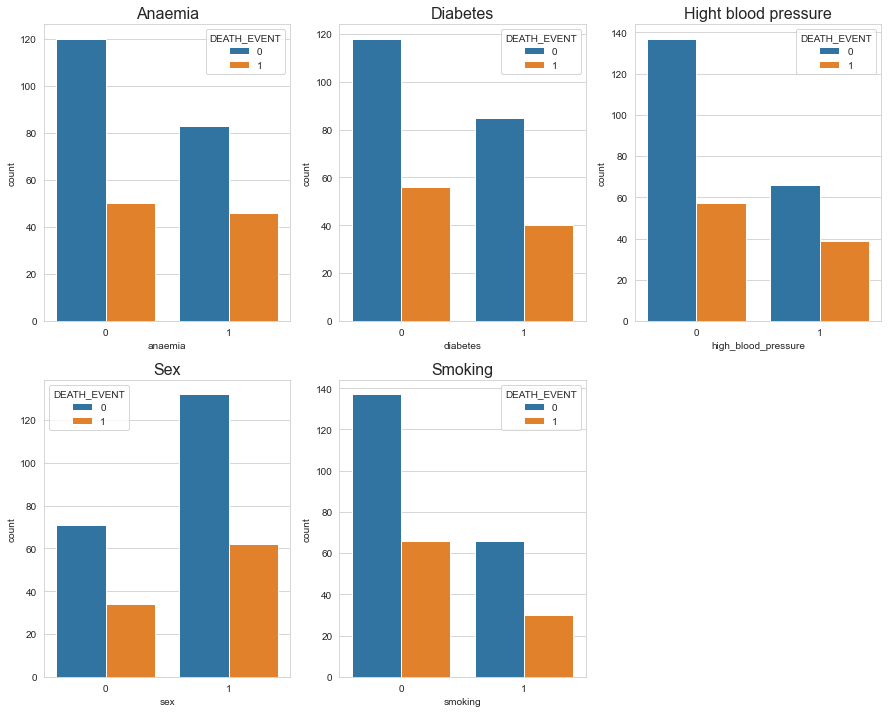

In [11]:
fig, ax = plt.subplots(2,3, figsize = [15, 12])
ax[0,0].set_title('Anaemia', fontsize = 16)
sns.countplot(data = df, x = 'anaemia', hue= 'DEATH_EVENT', ax = ax[0,0])
ax[0,1].set_title('Diabetes', fontsize = 16)
sns.countplot(data = df, x = 'diabetes', hue= 'DEATH_EVENT', ax = ax[0,1])
ax[0,2].set_title('Hight blood pressure', fontsize = 16)
sns.countplot(data = df, x = 'high_blood_pressure', hue= 'DEATH_EVENT', ax = ax[0,2])
ax[1,0].set_title('Sex', fontsize = 16)
sns.countplot(data = df, x = 'sex', hue= 'DEATH_EVENT', ax = ax[1,0])
ax[1,1].set_title('Smoking', fontsize = 16)
sns.countplot(data = df, x = 'smoking', hue= 'DEATH_EVENT', ax = ax[1,1])
ax[1,2].axis('off')
plt.show()

Next, we explore the numerical features, showing histograms, pairwise scatterplots, and pair kernel-density-estimation plots. Unfortunately, we do not find a clear separation pattern. For that reason, we expect that the classification task is far from being trivial.

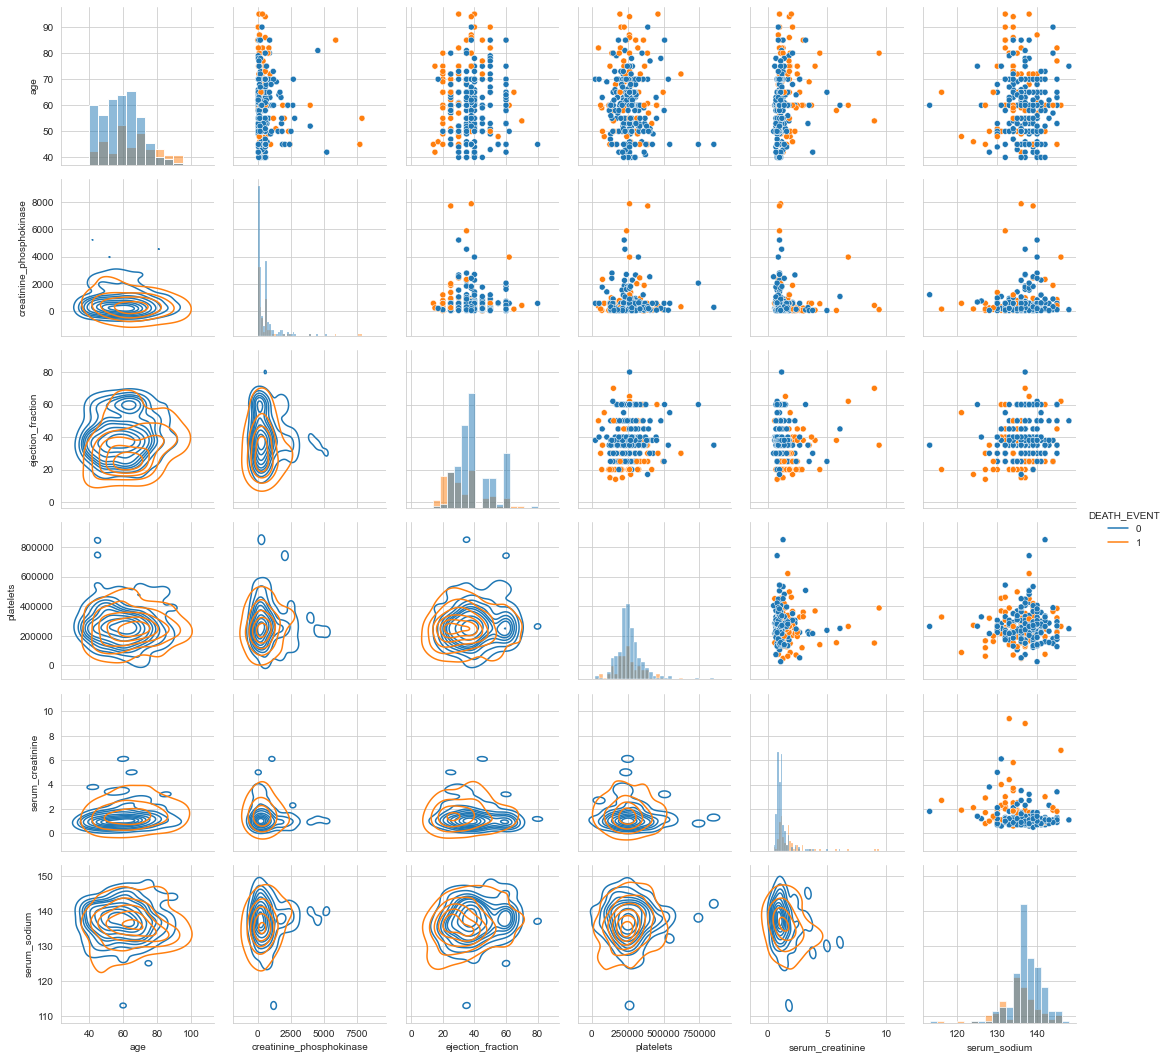

In [12]:
g = sns.PairGrid(df, vars =['age','creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium'], hue = 'DEATH_EVENT')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
g.add_legend()
plt.show()

On the other hand, we can observe that a lot of points turn out to be isolated from the point cloud. For that reason, we explore the possible presence of outliers through a boxplot for each numerical variable separately for the class label.

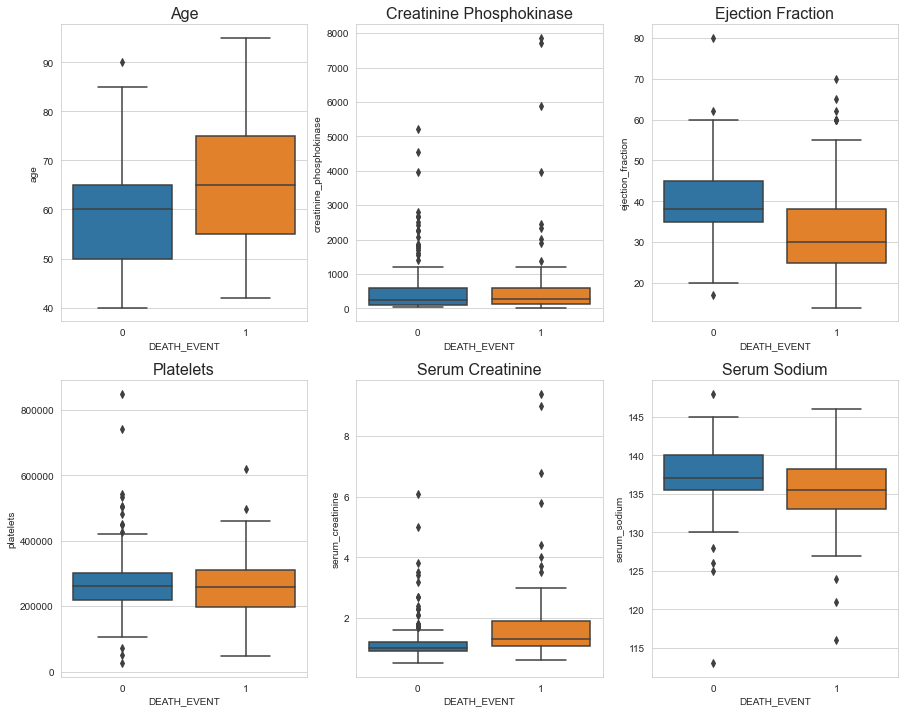

In [13]:
fig, ax = plt.subplots(2,3, figsize = [15, 12])
ax[0,0].set_title('Age', fontsize = 16)
sns.boxplot(data = df, y = 'age', x= 'DEATH_EVENT', ax = ax[0,0])
ax[0,1].set_title('Creatinine Phosphokinase', fontsize = 16)
sns.boxplot(data = df, y = 'creatinine_phosphokinase', x= 'DEATH_EVENT', ax = ax[0,1])
ax[0,2].set_title('Ejection Fraction', fontsize = 16)
sns.boxplot(data = df, y = 'ejection_fraction', x= 'DEATH_EVENT', ax = ax[0,2])
ax[1,0].set_title('Platelets', fontsize = 16)
sns.boxplot(data = df, y = 'platelets', x= 'DEATH_EVENT', ax = ax[1,0])
ax[1,1].set_title('Serum Creatinine', fontsize = 16)
sns.boxplot(data = df, y = 'serum_creatinine', x= 'DEATH_EVENT', ax = ax[1,1])
ax[1,2].set_title('Serum Sodium', fontsize = 16)
sns.boxplot(data = df, y = 'serum_sodium', x= 'DEATH_EVENT', ax = ax[1,2])
plt.show()

It's difficult to state whenever the shown outliers show be addressed to a wrong data imputation or an extreme clinical situation of a patient. However, the presence of extrema values can affect the models' fitting. Therefore, we conservatively consider the outliers as extreme clinical situations but during the preprocessing phase, after the train/test split we cut out some of the outliers from the training portion. Specifically, we consider outliers values that are really extrema and not the whole presented in the boxplots. So, now we heuristically define some variable-specific thresholds that we will use in the preprocessing phase for eliminating a small number of extreme points. 

In [14]:
cpk_outliers_thrs = 6000
ejf_outliers_thrs = 70
plt_outliers_thrs = 600000
src_outliers_thrs = 8
srs_outliers_thrs = 120

print(f"creatinine_phosphokinase outliers (above {cpk_outliers_thrs}) \t : {np.sum(df.creatinine_phosphokinase > cpk_outliers_thrs)}")
print(f"ejection_fraction outliers (above {ejf_outliers_thrs}) \t : {np.sum(df.ejection_fraction > ejf_outliers_thrs)}")
print(f"platelets outliers (above {plt_outliers_thrs}) \t : {np.sum(df.platelets > plt_outliers_thrs)}")
print(f"serum_creatinine outliers (above {src_outliers_thrs}) \t : {np.sum(df.serum_creatinine > src_outliers_thrs)}")
print(f"serum_sodium outliers (below {srs_outliers_thrs}) \t : {np.sum(df.serum_sodium < srs_outliers_thrs)}")

creatinine_phosphokinase outliers (above 6000) 	 : 2
ejection_fraction outliers (above 70) 	 : 1
platelets outliers (above 600000) 	 : 3
serum_creatinine outliers (above 8) 	 : 2
serum_sodium outliers (below 120) 	 : 2


## Preprocessing

Here, we describe the preprocessing operations that we apply to the dataset, in order to obtain more suitable features for the models' fitting. In brief, we split the dataset into training and test set, then we standardize the numerical attributes, and finally, we perform oversampling for balancing the training set.

First, we get a stratified train-test split with a test proportion of $20\%$, obtaining the two homonymous subsets : $(X_{train}, y_{train})$ and $(X_{test}, y_{test})$. Then, we define all the preprocessing operations regarding the training set, while the test remains unsullied and will be the reference for the model final evaluation. It is crucial to underline that the splitting is performed in a stratified way: training and test subsets will share the (approximately) same proportion of classes. 

In [15]:
from sklearn.model_selection import train_test_split
columns = df.columns
X = df.loc[:, columns[:-1]]
y = df.loc[:, 'DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=SEED_TRAIN_TEST_SPLIT, stratify= y)
print(f"The training set consists of {X_train.shape[0]} records,")
print(f"with a proportion of {100*np.round(np.mean(y_train),4)}% death, and {100*(1 - np.round(np.mean(y_train),4))}% survivals")
print(f"\nThe test set consists of {X_test.shape[0]} records,")
print(f"with a proportion of {np.round(100*np.round(np.mean(y_test),4),4)}% death, and {100*(1 - np.round(np.mean(y_test),4))}% survivals")

The training set consists of 239 records,
with a proportion of 32.22% death, and 67.78% survivals

The test set consists of 60 records,
with a proportion of 31.67% death, and 68.33% survivals


Next, we consider the training set and we looking for the presence of outliers based on the feature-specific thresholds that we have highlighted in the previous section. We remove all the training samples that are outside these bounds. As a result, $8$ samples have been removed.

In [16]:
print(f"creatinine_phosphokinase outliers (above {cpk_outliers_thrs}) \t : {np.sum(X_train.creatinine_phosphokinase > cpk_outliers_thrs)}")
print(f"ejection_fraction outliers (above {ejf_outliers_thrs}) \t : {np.sum(X_train.ejection_fraction > ejf_outliers_thrs)}")
print(f"platelets outliers (above {plt_outliers_thrs}) \t : {np.sum(X_train.platelets > plt_outliers_thrs)}")
print(f"serum_creatinine outliers (above {src_outliers_thrs}) \t : {np.sum(X_train.serum_creatinine > src_outliers_thrs)}")
print(f"serum_sodium outliers (below {srs_outliers_thrs}) \t : {np.sum(X_train.serum_sodium < srs_outliers_thrs)}")

# Outliers removals
conditions = (X_train.creatinine_phosphokinase < cpk_outliers_thrs) & (X_train.ejection_fraction < ejf_outliers_thrs) & (X_train.platelets < plt_outliers_thrs) & (X_train.serum_creatinine < src_outliers_thrs) & (X_train.serum_sodium > srs_outliers_thrs)
X_train = X_train.loc[conditions,:]
y_train = y_train.loc[conditions]

creatinine_phosphokinase outliers (above 6000) 	 : 2
ejection_fraction outliers (above 70) 	 : 1
platelets outliers (above 600000) 	 : 1
serum_creatinine outliers (above 8) 	 : 2
serum_sodium outliers (below 120) 	 : 2


Now, we want to transform our data: we have $6$ numerical features and $5$ binary variables. 

The binary variables are encoded in a one-hot fashion, i.e. $1$ for the presence of the underlying factor and $0$ for the absence. This encoding is already suitable for *Sklearn classifiers*, so we do not further manipulate them. 

On the other hand, even if the numerical features are already suitable for *Sklearn classifiers* they range across very different values, as the next plot shows. For some classifiers, this can be a problem. Think about *K-NN*, where the classification is guided through the computation of distances, so variables with higher amplitude dominate against the others, easily leading the model toward misclassifications. Even if we do not consider a distance-based classifier, this variability of ranges can easily cause numerical instabilities, as a consequence, we can get into a really unstable model. 

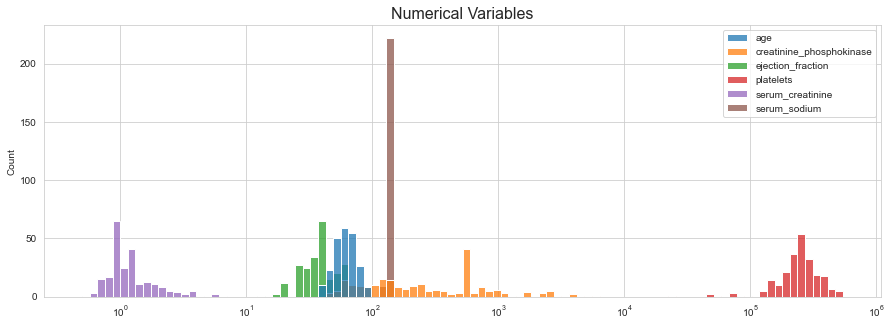

In [17]:
numeric_columns = ['age','creatinine_phosphokinase',  'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
binary_columns = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

fig, ax =plt.subplots(figsize = [15,5])
sns.histplot(data = X_train.loc[:,numeric_columns], ax = ax, bins = 100, log_scale = True)
ax.set_title('Numerical Variables', fontsize = 16)
plt.show()

The plot is clear, we have an extreme variability of ranges. We address this situation through **standardization**, i.e. we make each numerical feature with zero mean and unit variance. 

Specifically, we consider each feature as independent from the others and for each we compute the mean $\mu$ and the standard deviation $\sigma$, then we subtract $\mu$ and we divide by $\sigma$. Formally, let $z\in \mathbb{R}^m$ be a numerical feature vector, i.e. a numerical column of the dataset, we compute 
\begin{equation}
\mu = \frac{1}{m} \sum_{i=1}^m z_i, \quad \quad \sigma = \sqrt{ \frac{1}{m - 1} \sum_{i=1}^m (z_i - \mu)^2},
\end{equation}
then we get the standardized feature by computing,
\begin{equation}
z_{std}= \frac{z - \mu}{\sigma},
\end{equation}
the procedure is then repeated speraterly for each numerical feature.

A crucial aspect is that the mean and the standard deviation are computed from the training set only, while the transformation is applied to both sets. Indeed, this will not alter the test set but it only scales the variables in the same manner to the ones that the model learns.   

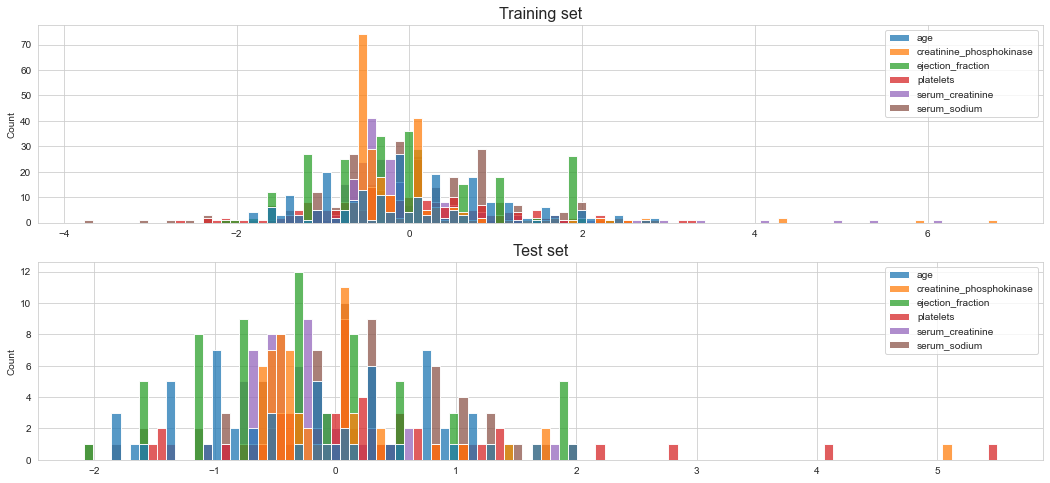

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(np.array(X_train.loc[:, numeric_columns]))
X_test_standardized = scaler.transform(np.array(X_test.loc[:, numeric_columns]))
fig, (ax1,ax2) =plt.subplots(2,1, figsize = [18,8])
ax1.set_title('Training set', fontsize = 16)
ax2.set_title('Test set', fontsize = 16)
sns.histplot(data = pd.DataFrame(X_train_standardized, columns = numeric_columns), ax = ax1, bins = 100)
sns.histplot(data = pd.DataFrame(X_test_standardized, columns = numeric_columns), ax = ax2, bins = 100)
plt.show()

We can see that the new features range from $-4$ to $7$, but mostly in the interval $[-2,2]$. The training and test histograms share similar shapes but also some differences. 

Finally, we combine numerical and binary features in a single object, separately for training and test.

In [19]:
features_names = numeric_columns + binary_columns
X_train = np.hstack((X_train_standardized, np.array(X_train.loc[:, binary_columns])))
X_test = np.hstack((X_test_standardized, np.array(X_test.loc[:, binary_columns])))

## Oversampling

As the last preprocessing operation we perform oversampling on the training set. Indeed, we have seen that the dataset is slightly imbalanced: around one-third of the samples concern death patients, while the remaining two-third refer to survived patients. Even if the imbalance meant is mild it can affect the models' fitting and performances. Think about *K-NN*, for any given point is inherently more probable that the neighbors of the point belong to the majority class. Similarly, the Decision Tree Classifier will bias the generation of the splits towards the dominant class. For that reason we want to balance the training set, in general, there are two possible strategies:
- *undersampling*,
- *oversampling*.

Undersampling consists of removing samples of the majority class until the dataset is balanced. However, this will lead to an important decrease in training size. In addition, we deal with a small dataset, so a further decrease in size will dangerously expose the models to overfitting. Even without thinking about overfitting, losing data means losing potentially important pieces of information from which the models learn, so it means potentially weakens the classifiers. On the other hand **oversampling** increases the dataset size, obtaining more and more samples of the minority class until the dataset is balanced.  There exist a lot of oversampling techniques and in this work, we experienced **SMOTE Oversampling**. To get an idea of how oversampling works is helpful to explain the simples approach, which is a variant of bootstrapping. It consists of drawn samples with replacement from the minority class until the dataset became balanced. As a result, we have a certain number of repeated samples at which the classification models will give more weight during fitting. 


### SMOTE Oversampling
Differently, **SMOTE Oversampling** generates samples of the minority class different from the ones already present in the original dataset. Indeed, the name is the acronym of *Synthetic Minority Over-sampling Technique*: it synthetically generates new samples starting from the old ones with a mathematical procedure. 

Let $x_i\in \mathbb{R}^n$ be a data point, the new sample $x_{new}$ will be generated considering its $k$ neareast-neighbors, where $k$ is a parameter of the method (typical values are $3$ or $5$). Let $x_{z_i}$ be a randomly choosen point among the $k$ neighbors, then the new sample is generated as follow
\begin{equation}
x_{new} = x_i + \lambda (x_{z_i} - x_i),
\end{equation}
where $\lambda$ is a random number in the range $[0,1]$. 
That is a random convex combination of the two randomly selected points. The following image illustrates the procedure.

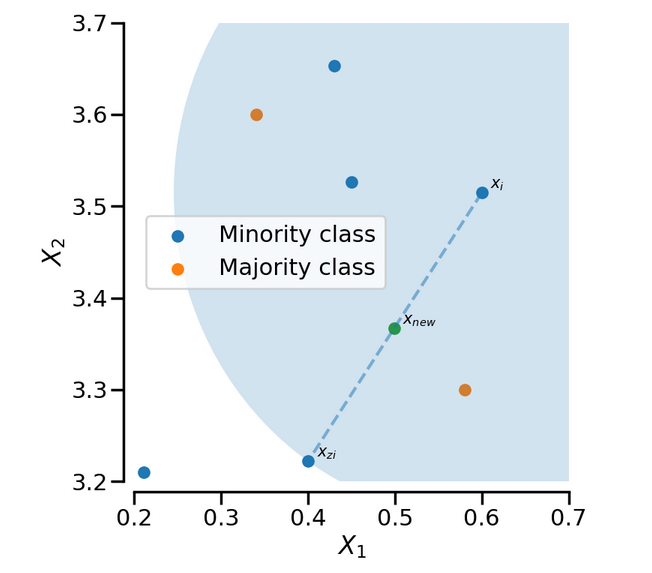

In [20]:
from IPython import display
display.Image("./SMOTE EXAMPLE.png", width = 400)

However, this is strategy is not proper for our situation. Because our dataset contains also binary variables and the standard *SMOTE oversampling* leads to meaningless results: the convex combination between binary variables can generate values different from $0$ and $1$. We use a specific implementation of *SMOTE* suitable for mixed numerical-nominal data types, specifically, we use the **SMOTENC** class of **imblearn** module. SMOTE-NC slightly changes the way a new sample is generated by performing specific and different activities for the binary and numerical features. Specifically, the numerical features are generated as described for the standard algorithm, while the binary variables are generated by picking the most frequent level of the nearest neighbors present during the generation. 

In the original training set, we have $159$ of survived patients and $72$ of dead ones, the algorithms will generate $87$ synthetic records of the minority class, as a result, the new training set will be balanced. 

In [21]:
from imblearn.over_sampling import SMOTENC
smote_nc = SMOTENC(random_state=SEED_SMOTE, categorical_features=np.arange(6, X_train.shape[1]))
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)
print(f"The training set consists of {X_train_resampled.shape[0]} records,")
print(f"with a proportion of {100*np.round(np.mean(y_train_resampled),4)}% death, and {100*(1 - np.round(np.mean(y_train_resampled),4))}% survivals")

The training set consists of 318 records,
with a proportion of 50.0% death, and 50.0% survivals


The new dataset is balanced, for a graphical perception we present also the comparison in terms of class proportion in the original and new training set.

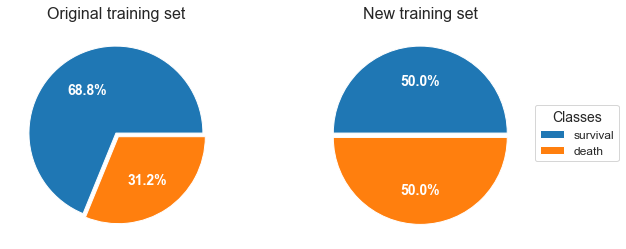

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10,4])

death_perc_old = np.mean(y_train)
surv_perc_old = 1 - death_perc_old
data_old = [surv_perc_old, death_perc_old]

death_perc = np.mean(y_train_resampled)
surv_perc = 1 - death_perc
data = [surv_perc, death_perc]

def func(pct):
    return "{:.1f}%".format(pct)


wedges, texts, autotexts = ax1.pie(data_old, autopct=lambda pct: func(pct),
                                  textprops=dict(color="w"), explode = [0,0.05])
plt.setp(autotexts, size=14, weight="bold")

wedges, texts, autotexts = ax2.pie(data, autopct=lambda pct: func(pct),
                                  textprops=dict(color="w"), explode = [0,0.05])

ax2.legend(wedges, ['survival', 'death'],
          title="Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize = 12, title_fontsize = 14)

plt.setp(autotexts, size=14, weight="bold")

ax1.set_title("Original training set", fontsize = 16)
ax2.set_title("New training set", fontsize = 16)

plt.show()

Finally, it is interesting to see what kind of new samples have been generated. For example, we could compare the original and new training set through a 2D-scatter plot of the two most important risk factors: *ejection fraction* and *serum creatinine*.

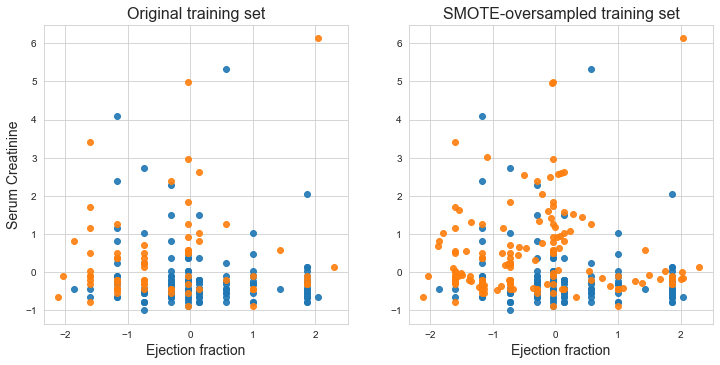

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12,5.5])
ax1.set_xlabel('Ejection fraction', fontsize = 14)
ax2.set_xlabel('Ejection fraction', fontsize = 14)
ax1.set_ylabel('Serum Creatinine', fontsize = 14)
ax1.set_title('Original training set', fontsize = 16)
ax2.set_title('SMOTE-oversampled training set', fontsize = 16)
ax1.scatter(X_train[y_train == 0,2], X_train[y_train == 0,4], alpha = 0.9)
ax1.scatter(X_train[y_train == 1,2], X_train[y_train == 1,4], alpha = 0.9)
ax2.scatter(X_train_resampled[y_train_resampled==0,2], X_train_resampled[y_train_resampled==0,4], alpha = 0.9)
ax2.scatter(X_train_resampled[y_train_resampled==1,2], X_train_resampled[y_train_resampled==1,4], alpha = 0.9)
plt.show()

We can see that a lot of new different points, and we can distinguish between new and old points only from the fact that the variable *ejection fraction* assume only a finite set of value (they are a percentage of blood pumping).

## Model Selection and Hyper-parameter tuning
In this section, we apply several classification models to our dataset. Specifically: for each classifier, we report a precise description of how it works; then, if the classifier shares hyperparameters we find the best configuration by means of a grid search with cross-validation; finally, we evaluate the classifier by means of confusion matrices and a classification report that shows all the classification metrics. The classifiers that we will consider are the following:
- K-Nearest Neighbors (K-NN),
- Logistic Regression.
- Decision Tree,
- Random Forest,
- Naive Bayes,
- Linear Discriminant Analysis (LDA),
- Quadratic Discriminant Analysis (QDA),
- Support Vector Machine (SVM).

We perform grid search, and model fitting over the training set obtained with our preprocessing pipeline (in the code this set is denoted as $(X_{train\_resampled}, y_{train\_resampled})$). Then, we evaluate the classifier over the training set without oversampling as well as the test set. In this way, we can understand the model capabilities toward the real data distribution from the point of view of samples seen during training as well as unseen data samples. The comparison is made first in terms of **confusion matrices** and then with classification metrics. The *Confusion Matrix* is a useful visual tool for getting an immediate idea of the classifier performances, we briefly report how it works.

|            	|  Confusion matrix 	|    	|
|:----------:	|:-----------------:	|:--:	|
|            	|  Predicted label  	|    	|
| True label 	|         0         	|  1 	|
|      0     	|         TN        	| FP 	|
|      1     	|         FN        	| TP 	|

That is, it counts the number of correct or incorrect predictions for each combination of predicted and true labels. Moreover, from this table we can derive quantitive performance metrics:
\begin{align}
\text{Accuracy} & = \frac{TP+TN}{TP+TN+FP+FN} \\ 
\text{Precision} & = \frac{TP}{TP+FP} \\ 
\text{Recall} & = \frac{TP}{TP+FN} \\ 
\text{F1-score} & = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} 
\end{align}

The *Accuracy* evaluates how much the classifier is accurate in general. While the other measures evaluate the classifier capabilities regarding the positive class (encoded by $1$ and indicating *death* patients). *Recall* measures the model capability of recalling the objects in the right class. While *Precision* quantifies the proportion of correct positive predictions over the total number of predictions assigned to this class. These two metrics are complementary and they are combined into the **F1-score**, which is the harmonic mean of the two. 

In our situation, the imbalancement of the dataset suggests marginally consider the *accuracy* metric, because it is clearly biased toward the majority class. On the other hand, we are really interested to develop a model able to correctly classify patients at risk of death. For that reason, the *F1-score* turns out to be the proper evaluation metric for our situation and it will be used in hyperparameter tuning as well as in model comparison. 

In [24]:
# HP Tuning
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
# Evaluation
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
# Utilities
import copy
from sklearn.base import BaseEstimator

classifiers = {}
cv_training_f1 = {}

In [25]:
def baseline_estimator_evaluation(estimator, X_data, y_data):
    cv = StratifiedKFold(10, random_state=SEED_HP_TUNING, shuffle=True)
    f1_cv_score = cross_val_score(estimator = estimator, X = X_data, y = y_data, groups = y_data,
                           scoring = make_scorer(f1_score), cv = cv)
    
    # cv = StratifiedKFold(10, random_state=SEED_HP_TUNING, shuffle=True)
    # acc_cv_score = cross_val_score(estimator = estimator, X = X_data, y = y_data, groups = y_data,
    #                      scoring = make_scorer(accuracy_score), cv = cv)
    print(f"10 fold CV F1-score : {np.round(np.mean(f1_cv_score),4)}")
    # print(f"10-CV Accuracy score : {np.round(np.mean(acc_cv_score),4)}")
    return f1_cv_score
    
def grid_search_cv(estimator, X_data, y_data, grid, score):
    cv = StratifiedKFold(10, random_state=SEED_HP_TUNING, shuffle=True)
    model = GridSearchCV(estimator, param_grid = grid, scoring = make_scorer(score), refit = True, cv = cv)
    model.fit(X_data,y_data)
    print(f"Best configuration : {model.best_params_}")
    print(f"10 fold CV F1-score : {np.round(model.best_score_, 4)}")
    return model 

def test_evaluation(estimator, X_data, y_data, score):
    y_pred = estimator.predict(X_data)
    s = score(y_data, y_pred)
    return s 

##  K-Nearest Neighbors (K-NN)
The **K-Nearest Neighbors** is an *instance-based classifier*: it does not build an internal model, but it simply stores instances seen during training in its memory. During classification, given a new data point, the model takes the "$k$" nearest neighbors of the point and classifies it according to the majority vote of the neighbors' labels. Hence, for each test point the model, in order to assess which are the nearest neighbors, should compute the pairwise distances between the whole training set. 

Formally, for defining the model we should choose:
- a distance metric $d(\cdot, \cdot)$,
- the number of neighbors that we want to consider, $k$.

During training, we simply store the available data $(X, y)$. During classification, for any new data point $x \in \mathbb{R}^n$, we consider $\mathcal{N}_k(x)$ as the set of the training indexes of $k$ nearest neighbors of the point $x$, according to the metric $d(\cdot, \cdot)$. Then, it classifies as   
\begin{equation}
C(x) = Arg\max_{c \in \mathcal{C}} \left|(\{j \in \mathcal{N}_k(x) : y_j = c \}\right|,
\end{equation}

where $\left| \cdot \right|$ is the cardinality of a set, and $\mathcal{C}$ is the set of classes that in our situation is $\{0,1\}$. That is, for every class we compute the number of neighbors that represent that class and we classify the new point as the class with the most representatives in the neighborhood.

### Hyperparameter tuning
The first parameter to discuss is the distance metric. Clearly, the choice of this parameter is crucial and can heavily affect the behavior of the method, in fact, it defines the criterium on which the algorithm can recognize which points are nearest. Standard real-value distance metrics, like *Euclidean* or *Manhattan*, might be not proper in our situation because we have also $5$ binary variables. Therefore, we implement also a distance function that treats differently binary and numerical variables. This new distance is the sum of a distance for numerical variables (*Euclidean*) and a distance for the boolean variables (*Matching*).

Formally, the *Euclidean distance* is, $\forall x,y \in \mathbb{R}^n$
\begin{equation}
||x - z ||_2 = \sqrt{\sum_{i=1}^n (x_i-z_i)^2},
\end{equation}
and the *Manhattan distance* is
\begin{equation}
||x - z ||_1 = \sum_{i=1}^n |x_i-z_i|.
\end{equation}
While, the *Matching* distance is $\forall x,z \in \{0,1\}^n$
\begin{equation}
matching(x,z) = \frac{|\{i : x_i\neq z_i\}|}{n},
\end{equation}
that is, the proportion of non equal entries of the two binary variables.

The "new" distance is the sum of the last two, moreover, the Manhattan distance is applied only to the first $6$ variables of the dataset, i.e. the numerical variables, while the Matching distance works on the remaining variables, which are binary.

The other hyperparameter is the number of neighbors, $k$. Set $k=1$ means that during classification we assign the class off to the closest point. Regarding binary classification problems only, if we set $k=3$ means that during classification we assign the label in which at least two neighbors agree. Setting $k$ to a generic odd number means that we classify accordingly to the majority of the neighbors.
In general, as we increase $k$ we decrease the effect of noise. But, at the same time increasing $k$ makes the classification boundaries weaker, in fact, a too high number of neighbors lead the methods to consider points that are not so close and even more probably belonging to a different class. So, we expect that the optimal $k$ is a small odd number. 

In summary as hyper-parameters we consider:
- the distance metric : Euclidean, Manhattan, and Mixed (Manhattan + Matching)
- k : all the odd numbers between $1$ and $21$

In [26]:
# define a distance metric for mixed data 
from sklearn.neighbors import DistanceMetric

def mixed_metric(x,y):
    dist_numerical = DistanceMetric.get_metric('manhattan')
    dist_bool = DistanceMetric.get_metric('matching') 

    num_numerical = 6
    d1 = dist_numerical.pairwise(np.array([x[:num_numerical],y[:num_numerical]]))[0,1]  # or [1,0]
    d2 = dist_bool.pairwise(np.array([x[num_numerical:],y[num_numerical:]]))[0,1]
    return d1 + d2

from sklearn.neighbors import KNeighborsClassifier
grid = {'n_neighbors' : np.arange(1,21,2), 
        'metric' : ['minkowski', mixed_metric, 'manhattan']}# 
clf1 = grid_search_cv(KNeighborsClassifier(), X_train_resampled,y_train_resampled, grid, f1_score)
classifiers['K-NN'] = copy.deepcopy(clf1)
cv_training_f1['K-NN'] = clf1.best_score_

Best configuration : {'metric': <function mixed_metric at 0x0000024074A7F9D8>, 'n_neighbors': 1}
10 fold CV F1-score : 0.8392


The best configuration is $k=1$ and the mixed distance metric. As we expect, the mixed distance is the most proper for this dataset: the choice of treat differently numerical and binary features turn out to be effective for capturing the correct distance between points. Surprisingly the best number of neighbors is $1$. This choice is very unexpected because the model could be heavily affected by random noise, however, the parameter is determined through cross-validation, in addition with a high *F1 score*, so we trust that this will be a good choice. 

The reason for this extreme choice could be also addressed to the fact that some of the training samples are synthetically generated by *SMOTE oversampling*, so many of the samples of class $1$ are natively close to each other. So, our preprocessing can slightly bias the selection of the parameter $k$ toward small numbers,  for that reason an even suboptimal parameter could be more appropriate. For a better understanding we show the plot of the cv-scores of the different number of neighbors for the selected mixed distance metric:

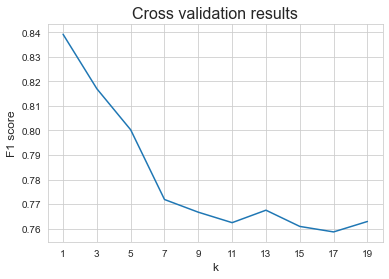

In [27]:
d =pd.DataFrame(clf1.cv_results_)
f1_s = np.array(d.loc[d.param_metric == mixed_metric, 'mean_test_score'])
x = np.arange(1,21,2)
fig, ax = plt.subplots()
ax.plot(x, f1_s)
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_title('Cross validation results', fontsize = 16)
ax.set_xlabel('k', fontsize = 12)
ax.set_ylabel('F1 score', fontsize = 12)
plt.show()

There is a clear decreasing trend as the number of neighbors increases. A safer choice of the parameter could be a small value but greater than $1$, for example, a good trade-off could be $k =3$. Anyway, this is empirical reasoning so let's continue for a while the analysis considering the parameter selected by grid search, and then proceed with presenting also the results for the choice of $k =3$. 

When $k=1$, we know that the model reaches trivially perfect performances in the training set: the closest point of a training point is the training point itself. As a confirmation, we show the classification report in the original training set.

In [28]:
print('Training set performances \n')
print(classification_report(y_train, clf1.predict(X_train)))

Training set performances 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00        72

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231



Now we can analyze the capability of the model in terms of confusion matrix, comparing the results obtained in the training set with the same in the test set. We know that the training confusion matrix is diagonal, we want to point out to what extent the test confusion matrix differs from this pattern.

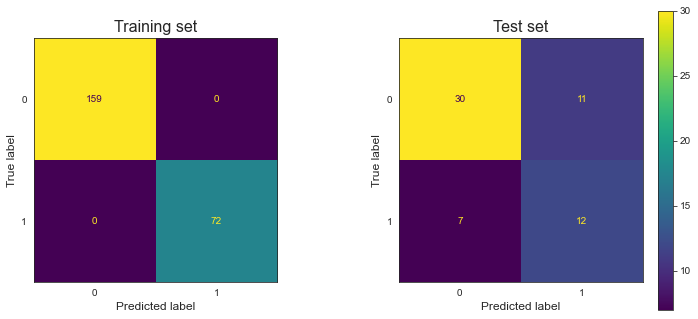

In [29]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train, y_train, ax = ax1)
m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

The difference is neat, the test confusion matrix is far from being diagonal. We get almost the same number of false-positive and true positive, so a poor precision. For a more detailed quantitative analysis we show the classification report on the test set.

In [30]:
print('Test set performances \n ')
print(classification_report(y_test, clf1.predict(X_test)))

Test set performances 
 
              precision    recall  f1-score   support

           0       0.81      0.73      0.77        41
           1       0.52      0.63      0.57        19

    accuracy                           0.70        60
   macro avg       0.67      0.68      0.67        60
weighted avg       0.72      0.70      0.71        60



As before, we can argue that the performances are far from ideal as in the training set. However, the method reaches good results for the class $0$ (survival). Nevertheless, the algorithm is one of the simples classification techniques and an F1-score of $0.57$ for the class of interest is a good starting point. 

Now, we analyze what happens if we had set $k=3$.

In [31]:
clf2 = KNeighborsClassifier(metric = mixed_metric, n_neighbors = 3).fit(X_train_resampled, y_train_resampled)
classifiers['K-NN, k = 3'] = copy.deepcopy(clf2)
cv_training_f1['K-NN, k =3'] = baseline_estimator_evaluation(clf2, X_train_resampled, y_train_resampled)

10 fold CV F1-score : 0.817


The following code shows the confusion matrices in the training and test set for the new model.

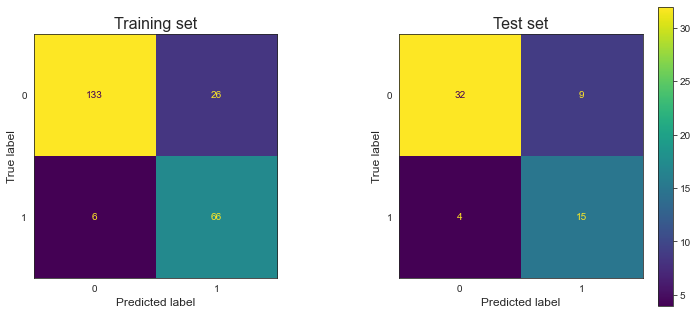

In [32]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf2, X_train, y_train, ax = ax1)
m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf2, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

The test pattern is decisely better, the model is more accurate and reduces both the false-positive both the false negative. 

In [33]:
print('Test set performances, k = 3 \n ')
print(classification_report(y_test, clf2.predict(X_test)))

Test set performances, k = 3 
 
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        41
           1       0.62      0.79      0.70        19

    accuracy                           0.78        60
   macro avg       0.76      0.78      0.76        60
weighted avg       0.81      0.78      0.79        60



The difference is even more clear if we look at the classification report, there is a significant increase in all performance metrics. Regarding this test set, the new model outperforms the same with $k=1$. However, for a fair determination of which one is better, one should repeat the experiment many times (with different train-test splits and the corresponding preprocessing pipeline) and compare the averaged performance metrics.

## Logistic Regression
The second model that we present is **Logistic Regression**. In breaf, it is a parametric classifier that learns a model for the probability of being in the positive class (which we indicate as $1$) conditionally on the input features. Specifically, it models the probability of being in class $1$ given an input feature vector $x\in \mathbb{R}$ as follow, 
\begin{equation}
\mathbb{P}\left(Y = 1|X = x\right) = \frac{exp\left(b+ \beta ' x\right)}{1 + exp\left(b+ \beta ' x\right)}= \frac{1}{1 + exp\left(-(b+ \beta ' x)\right)},
\end{equation}
where $\beta \in \mathbb{R}^n$ and $b\in \mathbb{R}$ are the parameter of the model and they will be learned from data. That is, the *logistic function* applied a linear transformation of the input vector, from which the name of the classifier. The parameters $\beta$ (known as *coefficients*) and $b$ (known as the *intercept*) are object of inference and they are determinated during the model's fitting.

Now we analyze the *logistic function*, for getting a better clue of how the model works. The function is expressed as follow, 
\begin{equation}
f(x) = \frac{e^x}{1 + e^x} =  \frac{1}{1 + e^{-x}}, \quad \forall x \in \mathbb{R}.
\end{equation}
The following plot shows its behavior: we can see that is a symmetric and monotonic increasing function, for values of the argument above $4$ the function is very close to $1$, and for values below $-4$ is very close to $0$. Hence, whenever we want to predict as $1$ we ideally want that the linear transformation of the input vector is as big as possible (the opposite old if we want to predict as $0$), the parameters of the model can control this capability.

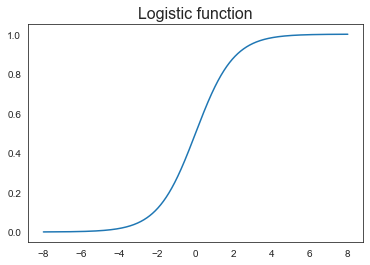

In [34]:
def logistic(x):
    return np.exp(x)/(1+np.exp(x))
x = np.linspace(-8,8,1000)
fx = logistic(x)
fig,ax = plt.subplots()
ax.plot(x, fx)
ax.set_title('Logistic function', fontsize = 16)
plt.show()

The parameters are determinbated by Maximum Likelihood Estimation (MLE). For convinience we espress the labels with the set of values $\{-1, 1\}$, instead of $\{0, 1\}$. This convention allow a compact reformulation of the probability of being in a class label, precisely,
\begin{equation}
\mathbb{P}\left(Y = y|X = x\right) = \frac{1}{1 + exp\left(-y(b+ \beta ' x)\right)},
\end{equation}
where $y\in \{-1,1\}$. Assuming indipendence, the *Log-Likelihood* of the problem can be written as
\begin{align}
L\left(X,y\right)  & = log\left(\prod_{i=1}^m \mathbb{P}\left(Y = y_i|X = x_i\right)\right) = \sum_{i=1}^m log\left( \mathbb{P}\left(Y = y_i|X = x_i\right)\right) \\ 
& = -  \sum_{i=1}^m log\left( 1 + exp\left(-y(b+ \beta ' x)\right)\right).\\
\end{align}
Then, instead of maximizing the *Log-Likelihood* we can minimize the same function flipped in sign, obtaining the following optimization problem
\begin{equation}
\min_{(b, \beta)\in \mathbb{R} \times \mathbb{R}^n} \sum_{i=1}^m log\left( 1 + exp\left(-y(b+ \beta ' x)\right)\right).
\end{equation}
The solution to the problem will be the parameters fitted by the model.

Moreover, the *Sklearn* implementation add by default a regularization term to the objective function with the aim of avoiding overfitting. Basically, **regularization** is a tecnique for performing the training of the model in controllate way. It is tipically implemeted by adding a so called regularization term to the loss function, that penalize the model capacity. In this situation, we limit the euclidean norm of the $\beta$ coefficient (not of the intercept $b$) by adding the corresponding norm into the objective function. The optimization problem with regularization turn out to be,
\begin{equation}
\min_{(b, \beta)\in \mathbb{R} \times \mathbb{R}^n} \frac{1}{2}||\beta||_2 + C \sum_{i=1}^m log\left( 1 + exp\left(-y(b+ \beta ' x)\right)\right),
\end{equation}
The regularization is weighted by the choice of the hyper-parameter $C$, the smaller the more strength the regularization is, in fact as we decrease $C$ we decrease the importance of the log-likelihood, as a consequence the impact of the regularization increases. There is not a good value in general for that quantity, because it heavily depends on the classification problem. So, we determine it by using cross-validation. We look for the best hyper-parameter into a grid of $101$ values between $0.1$ and $1$

Finally, we have a model capable of predicting the probability of being in class $1$ given an input feature vector, and we can use it to classify. The standard approach is to predict an input vector as class $1$ whenever the probability of being in this class is greater than the probability of being in the other class, i.e. class $0$. 

In [35]:
from sklearn.linear_model import LogisticRegression
grid = {'C' : np.linspace(0.1,1.1,101)}

print('Training Logistic Regression \n')
clf1 = grid_search_cv(LogisticRegression(), X_train_resampled,y_train_resampled, grid, f1_score)
classifiers['Logistic Regression'] = copy.deepcopy(clf1)

Training Logistic Regression 

Best configuration : {'C': 0.71}
10 fold CV F1-score : 0.7236


The best configuration is with $C = 0.71$, which is a medium level of regularization. So, expect that training and test performance will moderately close. Let's compare train and test performances in terms of the confusion matrix.

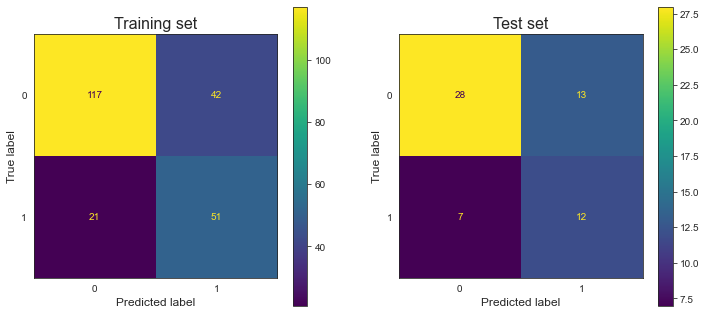

In [36]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train, y_train, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

The confusion matrices are quite similar, a more accurate analysis can be made by looking at the classification reports.

In [37]:
print('TRAINING PERFORMANCES')
print(classification_report(y_train, clf1.predict(X_train)))
print('\nTEST PERFORMANCES')
print(classification_report(y_test, clf1.predict(X_test)))

TRAINING PERFORMANCES
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       159
           1       0.55      0.71      0.62        72

    accuracy                           0.73       231
   macro avg       0.70      0.72      0.70       231
weighted avg       0.75      0.73      0.73       231


TEST PERFORMANCES
              precision    recall  f1-score   support

           0       0.80      0.68      0.74        41
           1       0.48      0.63      0.55        19

    accuracy                           0.67        60
   macro avg       0.64      0.66      0.64        60
weighted avg       0.70      0.67      0.68        60



During the test we get lower performances for each metric, however, in decisely lower extend with respect to the same situation for *K-NN*. We could say that the regularization parameter individuated with cross-validation is still too high and a lower value may improve the generalization capacity of the model.

The logistic model predicts according to the output probability, the standard technique assigns the label for which the probability is greater. A different approach can be:
- consider the probability of being in class $1$, 
- assign label $1$ whenever the probability is above a fixed threshold,
- otherwise, assign label $0$.
It is easy to understand that fix the threshold to $0.5$ is equivalent to follow the standard technique. 

This strategy can even improve the classifier, indeed, we find out the best threshold for our model with cross-validation searching into a grid of values. Specifically, we perform a $10$-fold cross-validation over the training set, with different random splits, and we select the best threshold according to the *F1-score*.

In [38]:
def predict_with_probability_threshold(model, threshold, X_data):
    probs = model.predict_proba(X_data)[:,1]
    y_pred = np.zeros(X_data.shape[0])
    y_pred[probs > threshold] = 1
    return y_pred

def find_threshold_cv(classifier, X, y, seed):
    thresholds = np.linspace(0, 0.5, 21)
    n_cv = 10
    scores = np.zeros((n_cv, len(thresholds)))
    skf = StratifiedKFold(n_splits=n_cv, random_state=seed, shuffle=True)
    i = 0
    for train_index, test_index in skf.split(X, y):
        clf = classifier()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        for j, t in enumerate(thresholds):
            y_pred = predict_with_probability_threshold(clf, t, X_test)
            scores[i,j] = f1_score(y_test, y_pred)
        i +=1
    s = np.mean(scores, axis = 0)
    idx = np.argmax(s)
    best_s, best_t = s[idx], thresholds[idx]
    best_s = np.round(best_s, 4)
    print(f"Best threshold : {np.round(best_t, 4)}, 10-fold CV F1 score : {best_s}")
    return best_s, best_t

class probability_binary_classifier(BaseEstimator):
        
    def __init__(self, classifier, threshold):
        super(BaseEstimator).__init__()
        self.classifier = classifier
        self.threshold = threshold
        self._estimator_type = 'classifier'
        self.classes_ = [0, 1]
        
    def fit(self, X, y):
        self.classifier.fit(X,y)
        return self
    
    def predict(self, X):
        y_pred = predict_with_probability_threshold(self.classifier, self.threshold, X)
        return y_pred
    
    def predict_proba(self, X):
        return self.classifier.predict_proba(X)
    
_, best_thrs = find_threshold_cv(lambda  : LogisticRegression(**clf1.best_params_) , X_train_resampled,
                                 np.array(y_train_resampled), SEED_HP_TUNING_THRESHOLD)
    
clf2 = probability_binary_classifier(clf1, best_thrs)

Best threshold : 0.475, 10-fold CV F1 score : 0.7408


The best threshold turns out to be $0.475$, that is we predict as $1$ whenever we have a probability of $47.5\%$ of risk of death for the patient. However, the classifier obtained with this threshold is only slightly different from the standard one, so we do not expect notable changes. We compare the test results of the two classifiers through confusion matrices.

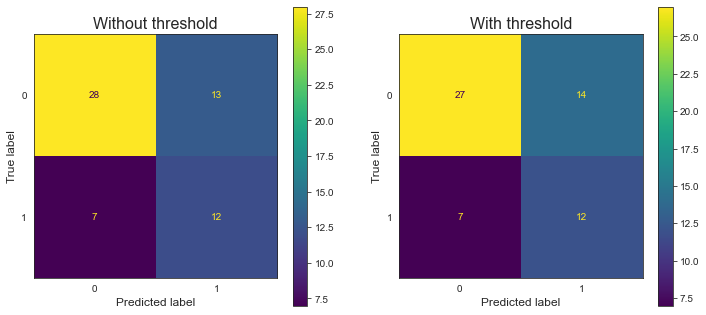

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Without threshold',fontsize = 16)
ax2.set_title('With threshold',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf2, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

The pattern is almost identical, the matrices differ by few units.

In [40]:
print('TEST PERFORMANCES : STANDARD CLASSIFIER')
print(classification_report(y_test, clf1.predict(X_test)))
print('\nTEST PERFORMANCES : THRESHOLD CLASSIFIER')
print(classification_report(y_test, clf2.predict(X_test)))

TEST PERFORMANCES : STANDARD CLASSIFIER
              precision    recall  f1-score   support

           0       0.80      0.68      0.74        41
           1       0.48      0.63      0.55        19

    accuracy                           0.67        60
   macro avg       0.64      0.66      0.64        60
weighted avg       0.70      0.67      0.68        60


TEST PERFORMANCES : THRESHOLD CLASSIFIER
              precision    recall  f1-score   support

           0       0.79      0.66      0.72        41
           1       0.46      0.63      0.53        19

    accuracy                           0.65        60
   macro avg       0.63      0.65      0.63        60
weighted avg       0.69      0.65      0.66        60



The reports confirm that the classifiers are almost identical, unexpectedly the second reaches slightly poorer performances. Nevertheless, classify in terms of a probability threshold can make the classifier more flexible. For example, we can decide that we want to classify as $1$ only whenever we are really sure, so we can fix a high threshold, like $0.8$ or $0.9$. On the other hand, we can say that we want to classify as $0$ even when we have a vague suspicion, so we can fix a small threshold, like $0.2$ or $0.3$. Moreover, this can be applied to a generic classifier, it is only required that the classifier learns a model for the distribution of the labels conditionally on the inputs. In fact, in the following, we will apply this technique to *Naive Bayes*, *LDA*, and *QDA*.

### Decision Tree Classifier
The **Decision Tree Classifier** learns a set of simple decision rules inferred from data. These rules dived the
feature space into high-dimensional rectangles, also called boxes. As a result, the tree can be seen as a piecewise constant decision function. 

Formally, let $J$ be the total number of boxes we look for partitions $(R_1, ..., R_J)$ that are the solution of the problem
\begin{equation}
\min_{(R_1, ..., R_J) \in \mathcal{R}} \sum_{j=1}^J V(\hat{p_j}),
\end{equation}
where $\mathcal{R}$ is the set of all possible partitions of the feature space, and 
\begin{equation}
\hat{p_j} = \frac{1}{|R_j|}\left(\sum_{(x_i,y_i)\in R_j}\mathbb{1}(y_i = 0), \sum_{(x_i,y_i)\in R_j}\mathbb{1}(y_i = 1)\right),
\end{equation}
is the probability vector of the class distribution in the box $R_j$.

While $V(\cdot)$ is an impurity measure and can be *Gini index*,
\begin{equation}
V(\hat{p_j}) = \sum_{c\in \{0,1\}} \hat{p_{jc}}(1 - \hat{p_{jc}}),
\end{equation}
or *Entropy*,
\begin{equation}
V(\hat{p_j}) = - \sum_{c\in \{0,1\}} \hat{p_{jc}}\log{(\hat{p_{jc}})}.
\end{equation}
Unfortunately, the problem is computationally unfeasible: we can consider all the possible partitions of the feature space into boxes. For this reason, the algorithms follow a *top-down gready* approach, known as **recursive binary splitting**. The approach is top-down because it begins on top of the tree (no partitions) and at each step, it selects a feature for determinating a split that separates the dataset into two new halves, each split is represented via two new branches further down on the tree. The algorithm is gready because at each step the local optimal split is selected.

In more detail, the building of the decision tree consists of a recursive splitting of the dataset until a stopping criterion is reached. In the beginning, we are at the root node and we consider the whole dataset and we look for the best split that separates the dataset into two subsets, each subset identify a child node. Then, for each child node, we select a new local optimal split that separates the portion of the dataset of the corresponding node into two new subsets, each subset identifies a new child node. The procedure recursively proceeds in the same manner and stops when a stopping criterion is reached. 

Formally the algorithm works as follow: let $Q_m$ be the data in node $m$, and $\theta= (j,x_j)$ a candidate split, consisting of the feature $j$ and the threshold $x_j$. This candidate splt the data $Q_m$ into two subset : $Q_m^{left}(\theta)$ and $Q_m^{right}(\theta)$, where 
\begin{equation}
Q_m^{left}(\theta) = \{(x,y)\in Q_m : x\leq x_j\}, \quad \quad Q_m^{right}(\theta) = \{(x,y)\in Q_m : x > x_j\}.
\end{equation}
The quality of a candidate split is evaluated from an impurity measure $V(\cdot)$ applied to the label distribution in each of the two subsets. Let $H(\cdot)$ be the composite function that calculates the label distribution from input data and then apply the impurity measure $V(\cdot)$ (Gini index or Entropy) on it. The quality of the candidate split can be written as 
\begin{equation}
G\left(Q_m^,\theta\right) = \frac{|Q_m^{left}(\theta)|}{|Q_m|}H\left(Q_m^{left}(\theta)\right) + \frac{|Q_m^{right}(\theta)|}{|Q_m|}H\left(Q_m^{right}(\theta)\right),
\end{equation}
that is, the weighted sum of the impurities of the two edges of the split.

At each step the algorithms select the split with minimal impurity, that is 
\begin{equation}
\theta^* = arg\min_{\theta}{G\left(Q_m^,\theta\right)}.
\end{equation}
Hence, the algorithm selects both the best feature that should be considered in each split both the threshold that defines the split for that feature. Noteworthy, from the nature of the procedure it follows that the first split selected, refers to the feature that best separates the whole dataset, i.e. the most important feature for the model. 

The algorithm continues recursively until a stopping criterion is reached. There are several possible stopping criteria and they are the object of hyperparameter tuning:
- maximum depth reached,
- minimum number of samples required for splitting an internal node reach,
- $Q_m$ consists of only one record, this is the default criteria.

The default criteria do not put bounds on the growth of the tree because the growing halts when it cannot grow anymore, and could easily lead to overfitting.

During classification, given the input vector $x$, we can determinate a path from the root to a leaf node identified by the sequence of conditions (splits) that $x$ satisfy, then we predict as the label with the highest probability at the leaf node, or equally as the label with most representatives. These paths can be also seen as decision rules since given an input vector they decide which label should be assigned.

### Hyper-parameter tuning
The first parameter that should be considered is the impurity criterium, which can be *Gini index* or *Entropy*. Then, we should determine the stopping criteria by a combination of the maximal depth and the minimum number of samples in an internal node. These parameters determinate the so-called **pre-pruning**, that is limit the growth of the tree at prior 
The maximal depth put a bound on the deep of the tree. While the minimum number of samples in an internal node stops the expansion of a node when the number of samples at this node is below the input value. 

In [41]:
from sklearn.tree import DecisionTreeClassifier
#        'ccp_alpha': np.linspace(0,1,11), 
grid = {'criterion' : ['gini', 'entropy'],
       'max_depth': np.arange(3,20),
       'min_samples_split': [2, 5, 10, 20]}
clf1 = grid_search_cv(DecisionTreeClassifier(random_state = SEED_MODEL_STATE), X_train_resampled, y_train_resampled, grid, f1_score)
classifiers['Decision Tree'] = copy.deepcopy(clf1)
cv_training_f1['Decision Tree'] = clf1.best_score_

Best configuration : {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20}
10 fold CV F1-score : 0.7928


The best configuration select *Entropy* as impurity criterium, a *maximum depth* of $4$ and the *minimum samples per split* to $20$. The last arguments lead to a very small tree. 

Let's compare the train and test performances of the tree through confusion matrices.

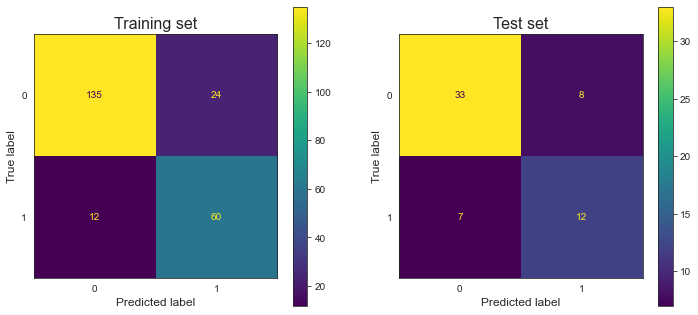

In [42]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train, y_train, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

We can immediately understand that the model shares good classification capability of the survivals, while it fails more in predicting deaths.

In [43]:
print('TRAINING PERFORMANCES')
print(classification_report(y_train, clf1.predict(X_train)))
print('\nTEST PERFORMANCES')
print(classification_report(y_test, clf1.predict(X_test)))

TRAINING PERFORMANCES
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       159
           1       0.71      0.83      0.77        72

    accuracy                           0.84       231
   macro avg       0.82      0.84      0.83       231
weighted avg       0.85      0.84      0.85       231


TEST PERFORMANCES
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        41
           1       0.60      0.63      0.62        19

    accuracy                           0.75        60
   macro avg       0.71      0.72      0.72        60
weighted avg       0.75      0.75      0.75        60



Interestingly, we can plot the obtained decision tree, understanding which feature and threshold define every single split. During classification, we can interpret a prediction of any input feature following the path from the root node to a leaf for which the input meets all conditions. Later we make an example of this procedure.  

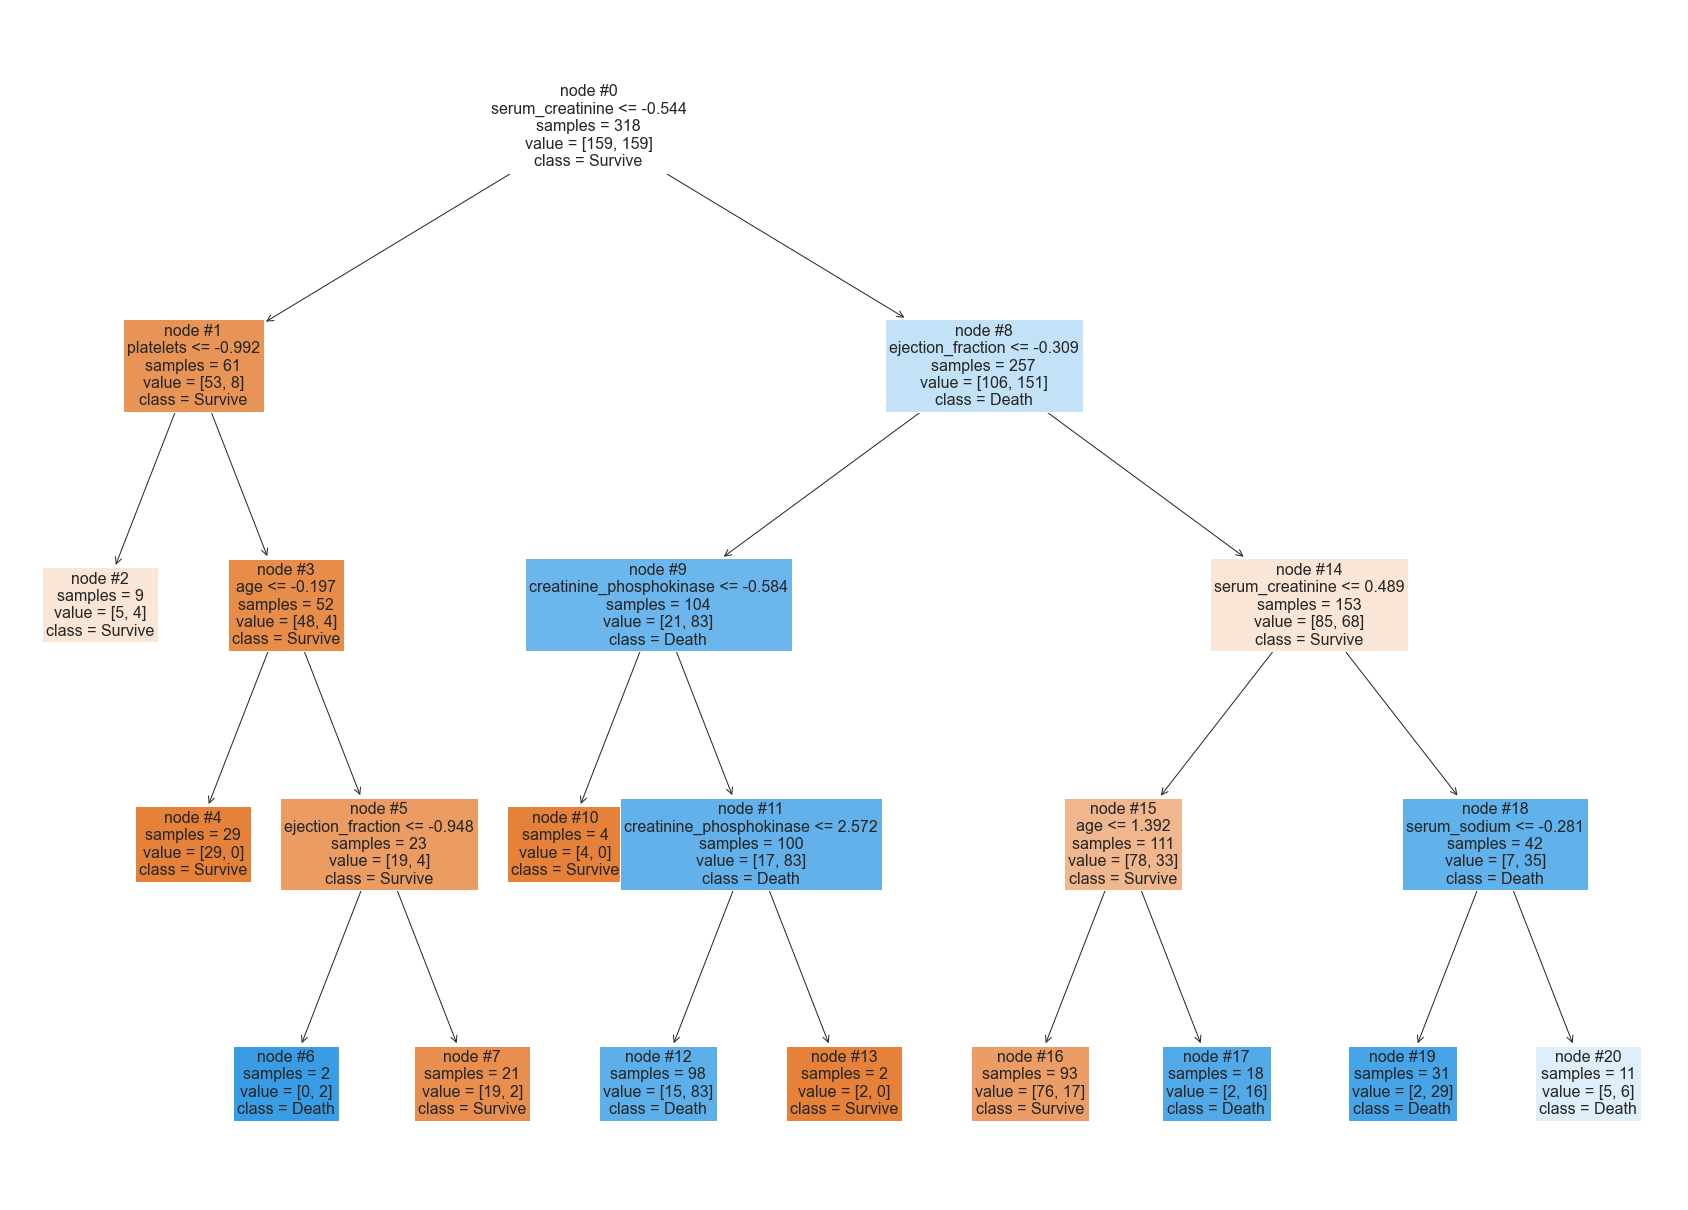

In [44]:
from sklearn.tree import plot_tree
fig,ax = plt.subplots(figsize =[30,22])
plot_tree(clf1.best_estimator_, ax = ax, feature_names = features_names,
          class_names = ['Survive', 'Death'], fontsize = 16, filled = True, node_ids = True, impurity = False)
plt.show()

Blue cells indicate to predict as class $1$ (*death*) while orange cells indicate a predict as a class *0* (*survival*). Every cell shows also the proportion of classes in the dataset subset of the corresponding node, from which the classification probabilities are defined. From the tree structure, we can also understand some weaknesses of the model. Indeed, we can see leaf nodes that are slightly faded, these can be regarded as undecided nodes in which the probability distribution is quite spread among the classes: these nodes could easily become a source of misclassification.

Next, we understand how the classification procedure works through an example.

In [45]:
d = pd.DataFrame(X_test, columns = features_names)
d.head(1)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.138874,0.072694,-1.597476,0.095016,0.585105,-1.603017,0.0,0.0,1.0,1.0,0.0


In [46]:
indexes = clf1.best_estimator_.decision_path(X_test[0:1,:]).indices
lbl = clf1.predict(X_test)[0]
print(f"Groud Truth : label {y_test[0]} (patient DEATH)")
print(f"Decision : label {lbl} (patient DEATH)")
print(f"Node sequence : {indexes}")

Groud Truth : label 1 (patient DEATH)
Decision : label 1 (patient DEATH)
Node sequence : [ 0  8  9 11 12]


We can have a nice interpretation of the decision for this record. The *serum creatinine* is above the level of $-0.544$ the *ejection fraction* is below the level of $-0.309$ and finally the *creatinine phosphokinase* is between $-0.584$ and $2.572$. Interestingly, we find that in this situation the *creatinine phosphokinase* has a crucial role, indeed, if the value of such feature would be below the level $-0.584$ the record would be predicted survival of the patient. 

Looking further at the tree structure, we can observe that the variable *serum creatinine*, is the most important for the decision tree. Indeed, as we have anticipated, due to the top-down gready selection the first variable select is the one that separate best the whole dataset with a single split. Moreover, also the *ejection fraction* and *creatinine phosphokinase* seems to have an important role. 

Interestingly, the *Decision Tree Classifier* can determine the importance of each feature in terms of the impurity gain maturated during the growing of the tree. Specifically, the importance of a given feature is determined by summing up all the decreases in terms of impurity maturated in each split where the feature is selected.  

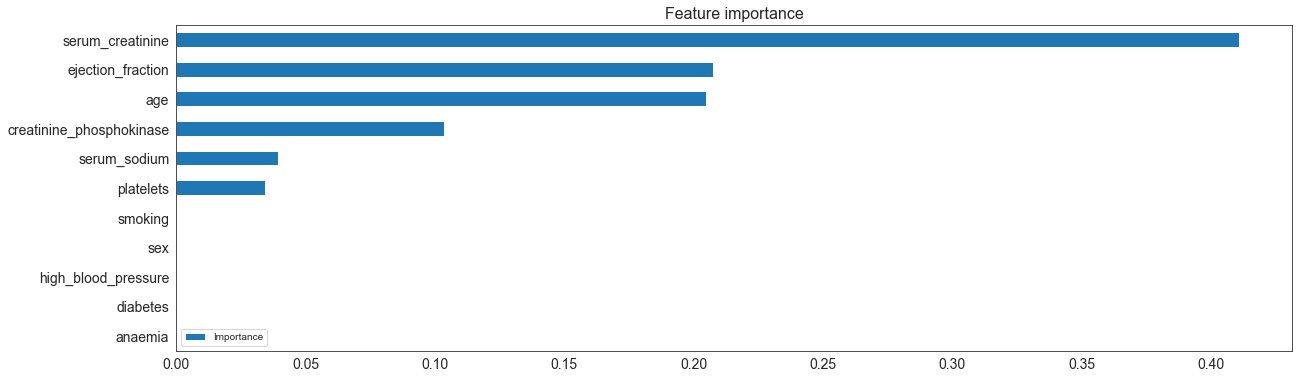

In [47]:
fig, ax = plt.subplots(1, figsize=(20,6))

d = pd.DataFrame({'Importance': clf1.best_estimator_.feature_importances_}, index = features_names)
d.sort_values('Importance', axis = 0, inplace = True)
d.plot.barh(ax=ax, fontsize = 14)
ax.set_title('Feature importance', fontsize = 16)
plt.show()

We can see that the ones and the only numerical feature are considered as important by the algorithm, and the famous risk factors are the most important.

## Random Forest Classifier 
The **Random Forest Classifier** is an ensemble of *Decision Tree Classifiers* each of these trained on a bootstrapped dataset, i.e. drawn by sample with replacement from the original training set. During, a classification it takes into account the contribution of each tree, specifically: the predicted class probabilities of an input sample are computed as the mean predicted class probabilities of the trees in the forest. The idea is that the injected randomness in the forest yields decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out, leading to a more robust probability distribution. Random forests could then reduce the variance by combining diverse trees, and empirical evidence shows that the variance reduction is often significant hence yielding an overall better model.

The number of trees in the forest is a hyperparameter of the model, the bigger the less variance the estimator has.  The more estimators we have the better, however, it increases also the computational cost. Moreover, empirical evidence shows that up to a certain point we have no improvement in performance even if we increase the number of trees. So, it is convenient to look for a good trade-off in the number of estimators.  

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of a fixed size. This last is another important hyper-parameter of the model. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good values are all the features available or the square root of this quantity. 

Moreover, since *Random Forest* is an ensemble of *Decision Tree* they share common parameters, like the *maximal depth*, the *minimum sample per split*, and the *impurity criterion*. Each hyper-parameter is selected through grid search with cross-validation.

In [48]:
from sklearn.ensemble import RandomForestClassifier
grid = {'criterion' : ['gini', 'entropy'],
       'max_depth': np.arange(3,21),
       'max_features': [None, 'sqrt'],
       'min_samples_split': [2, 5,10,20],
       'n_estimators' : [10, 50, 100]}
clf1 = grid_search_cv(RandomForestClassifier(random_state = SEED_MODEL_STATE), X_train_resampled, y_train_resampled, grid, f1_score)
classifiers['Random Forest'] = copy.deepcopy(clf1)

Best configuration : {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 50}
10 fold CV F1-score : 0.8364


The best configuration selected is: 
- a total of $50$ trees,
- use all the available features at each split,
- entropy as splitting criterium, a maximum depth of $10$ and the minimum number of samples per split to $5$.


The last list of parameters leads to more widely grown trees than in the situation with only a single decision tree. So, this meets the idea of the model: random forest leaves each tree to slightly overfit the bootstrapped data in order to almost decoupled decision trees.  

As with *Decision trees* we can determine the feature importance, but here the importance of each feature is averaged out among all the trees in the forest. As a result, we get a more reliable estimate of the importance.

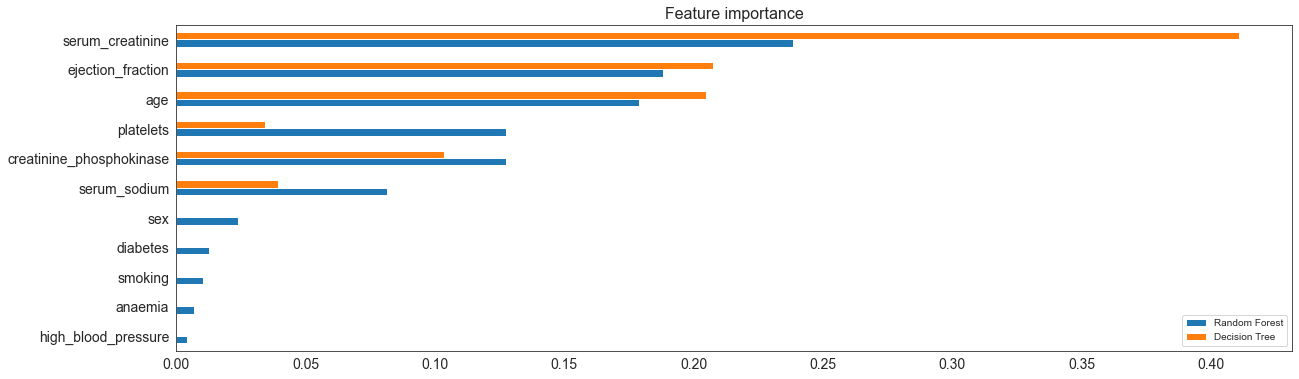

In [49]:
fig, ax = plt.subplots(1, figsize=(20,6))
d = pd.DataFrame({'Random Forest': clf1.best_estimator_.feature_importances_, 
                   'Decision Tree': classifiers['Decision Tree'].best_estimator_.feature_importances_}, index = features_names)
d.sort_values('Random Forest', axis = 0, inplace = True)
d.plot.barh(ax=ax, fontsize = 14)
ax.set_title('Feature importance', fontsize = 16)
plt.show()

Next, we compare train and test results.

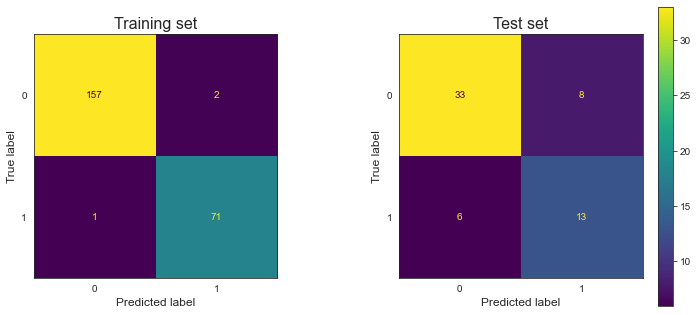

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train, y_train, ax = ax1)
m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

In [51]:
print('TRAINING PERFORMANCES')
print(classification_report(y_train, clf1.predict(X_train)))
print('\nTEST PERFORMANCES')
print(classification_report(y_test, clf1.predict(X_test)))

TRAINING PERFORMANCES
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       159
           1       0.97      0.99      0.98        72

    accuracy                           0.99       231
   macro avg       0.98      0.99      0.98       231
weighted avg       0.99      0.99      0.99       231


TEST PERFORMANCES
              precision    recall  f1-score   support

           0       0.85      0.80      0.83        41
           1       0.62      0.68      0.65        19

    accuracy                           0.77        60
   macro avg       0.73      0.74      0.74        60
weighted avg       0.77      0.77      0.77        60



The ensemble of trees leads to stronger performances, we get a good result in terms of precision as well as recall, obtaining a (test) *F1-score* of $0.65$ (while with Decision Tree it was $0.62$).

## Naive Bayes Classifier
One of the simplest classification models is the **Naive Bayes Classifier**, which is based on the *Bayes Theorem* for computing the posterior probability, and endowed with a simplifying assumption for easily computing such probability. First, we present **Bayes Classifier**, then we introduce the *naive assumption* that determines the homonymous classifier. 

In a classification context, the *Bayes Theorem* states that the posterior probability of being in class $y$ given an input vector $x \in \mathbb{R}^n$ can be written as follow,
\begin{equation}
\mathbb{P}\left(Y = y|X = x\right) = \frac{   \mathbb{P}\left(Y = y\right)  \mathbb{P}\left(X = x | Y = y\right) }{ \mathbb{P}\left(X = x\right)},
\end{equation}
where $\mathbb{P}\left(Y = y\right)$ and $\mathbb{P}\left(X = x\right)$ are the prior probabilities for the class label and the input vector respectively, while $\mathbb{P}\left(X = x | Y = y\right)$ is the probability density of the input vector $x$ conditionally on $y$. 
Then, we can use the following decision rule,
\begin{equation}
C(x)= arg\max_{y \in \mathcal{C}} \mathbb{P}\left(Y = y|X = x\right) = arg\max_{y \in \mathcal{C}} \mathbb{P}\left(Y = y\right)  \mathbb{P}\left(X = x | Y = y\right),
\end{equation}
for determinating a classification model, this is **Bayes Classifier**. Note that we can discard the denominator since it does not depends on $y$, so it does not contribute during optimization. 
Despite its simple formulation, this classifier is far from being trivial. Indeed, it is the theoretical upper bound of each possible classification model, that is the best classifier that we can develop. However, practically we are not able of using it: usually, we do not know the probability distribution of our data. The problem relies on the conditional probability of the input vector because it is a possibly high-dimensional distribution about which usually we have no prior information. Indeed, even if we do not know in advance the prior distribution of the class label, we can easily estimate it by the label proportions on the training data. 

A possible strategy for overcoming the problem is making a strong assumption: the features are independent, conditionally on $y$. This assumption is knwon as the *naive assumption*, and defines a class of models called **Naive Bayesian Classifiers**. Under the naive assumption we can write the posterior probability as follow,
\begin{equation}
\mathbb{P}\left(Y = y|X = x\right) \propto \mathbb{P}\left(Y = y\right)  \prod_{j=1}^n \mathbb{P}\left(X_j = x_j | Y = y\right),
\end{equation}
and then, classify according the previous decision rule.  
Now, even if we do not know the analytical distribution of the features there are a lot of statistical techniques for fitting a one-dimensional distribution. For example, a strategy can be: assuming that each feature is normally distributed, estimate mean and variance from the training set, and finally consider as distribution a normal distribution with the obtained mean and variance. This strategy is implemented in *Sklearn* in the **GaussianNB** class that we use immediately later. Note that, even if the *naive assumption* is generally not true it dramatically simplifies the probability computation allowing the execution of the method. 

In our situation we have $6$ numerical variables and $5$ binary ones, so we have define two strategy for estimating the feature-probabilities, separating for the kind of attribute. *Sklearn* implements also a Naive Bayesian Classifier that can handle binary data, which is called **BernoulliNB**. This class, calculate the features distribution as follow
\begin{equation}
\mathbb{P}\left(X_j = x_j | Y = y\right) = \pi_j^{(y)} \cdot \mathbb{1}\left(x_j = 1\right) + (1-\pi_j) \cdot \mathbb{1}\left(x_j = 0\right), \quad \forall x_j\in\{0,1\},
\end{equation}
where $X_j$ is a binary feature and $\pi_j^{(y)}$ is the proportion of the level $1$ of the feature $j$ when the label is $y$. On the other hand, the *GaussianNB* calculate the features distribution as follow
\begin{equation}
\mathbb{P}\left(X_j = x_j | Y = y\right) = \frac{1}{\sqrt{ 2\pi\sigma_j^{(y)} } } \exp{ \frac{ \left(x_j - \mu_j^{(y)}\right)^2 }{ 2 \sigma_j^{(y)} }}, \quad \forall x_j\in\mathbb{R},
\end{equation}
where $X_j$ is a numerical feature and $\mu_i^{(y)}$ and $\sigma_j^{(y)}$ are mean and variance for the feature $j$ and class $y$, determinated by standard statistical estimation. 

Each of these models can compute the posterior probability of the class label given an input vector of the correct type. In order to exploit *Naive Bayesian Classifiers* in our situation we can merge the two models as follow:
- every input vector $x$ can be seen as a tuple $(x',x'')$, where $x'$ is numerical while $x''$ is binary; 
- we can fit the models separately, passing them only the correct attributes;
- we can obtain an overall probability distribution as follow,
\begin{equation}
p(y|x) = \frac{6}{11} p_{gaussian}(y|x) + \frac{5}{11} p_{bernoulli}(y|x), 
\end{equation}
where $p_{gaussian}(y|x')$ the posterior probability of being in class $y$ given the (numerical) input vector $x'$ and as $p_{bernoulli}(y|x'')$ the posterior probability of being in class $y$ given the (binary) input vector $x''$. The two quantities are weigthed by the proportion of attributes considered.
- Finally, we can classify accordingly to the *Bayes Decision Rule*.

The model has not hyper-parameter, so we simply evaluate it by cross-validation, and then we fit the model on the whole training set.

In [52]:
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

class my_naive_bayes(BaseEstimator):
    
    def __init__(self):
        super(BaseEstimator).__init__()
        self.gaussian = GaussianNB()
        self.bernoulli = BernoulliNB()
        self._estimator_type = 'classifier'
        self.classes_ = [0, 1]
        self.num_numerical = 6
        
    def fit(self, X, y):
        self.gaussian.fit(X[:,:self.num_numerical],y)
        self.bernoulli.fit(X[:,self.num_numerical:],y)
        return self
        
    def predict_proba(self, X):
        p1 = self.gaussian.predict_proba(X[:,:self.num_numerical])
        p2 = self.bernoulli.predict_proba(X[:,self.num_numerical:])
        p = (6/11)*p1 + (5/11)*p2/2 
        # p = p1/2 + p2/2 
        return p
    
    def predict(self, X):
        p = self.predict_proba(X)
        y_pred = np.argmax(p, axis = 1)
        return y_pred

print('Training Naive Bayes classifier \n')
clf1= my_naive_bayes().fit(X_train_resampled, y_train_resampled)
f1_s = baseline_estimator_evaluation(my_naive_bayes(),X_train_resampled, y_train_resampled)
classifiers['Naive Bayes'] = copy.deepcopy(clf1)

Training Naive Bayes classifier 

10 fold CV F1-score : 0.6877


Next, we compare train and test results.

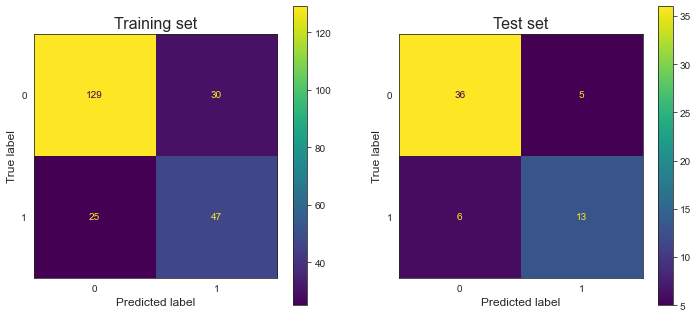

In [53]:
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train, y_train, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

We can see a very similar pattern in the two matrices: the model performs well both during training and testing. Moreover, the model gets a lot of correct predictions and a moderate number of false positives and false negatives. 

In [54]:
print('TRAINING PERFORMANCES')
print(classification_report(y_train, clf1.predict(X_train)))
print('\nTEST PERFORMANCES')
print(classification_report(y_test, clf1.predict(X_test)))

TRAINING PERFORMANCES
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       159
           1       0.61      0.65      0.63        72

    accuracy                           0.76       231
   macro avg       0.72      0.73      0.73       231
weighted avg       0.77      0.76      0.76       231


TEST PERFORMANCES
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.72      0.68      0.70        19

    accuracy                           0.82        60
   macro avg       0.79      0.78      0.79        60
weighted avg       0.81      0.82      0.82        60



With the classification report, we can appreciate even more the model. 
The results are surprising, the models show an unexpected increase in all performance metrics moving from train to test evaluations. So, despite the simplicity of the model, it shows a great generalization capability.

Interestingly, we can also classify in terms of probability thresholds as we have introduced before. We search with cross-validation a probability threshold that maximizes the *F1-score*.

In [55]:
_, best_thrs = find_threshold_cv(lambda  : my_naive_bayes() , X_train_resampled,
                                 np.array(y_train_resampled), SEED_HP_TUNING_THRESHOLD)

    
clf2 = probability_binary_classifier(clf1, best_thrs)

Best threshold : 0.3, 10-fold CV F1 score : 0.7374


The best threshold turns out to be $0.30$, that is we predict as $1$ whenever we have a probability of $30\%$ of risk of death for the patient. This new classifier should be widely different from the previous one in terms of behavior, indeed, we expect that *death* patients will be predicted more often. We compare the two classifiers in terms of test performances.

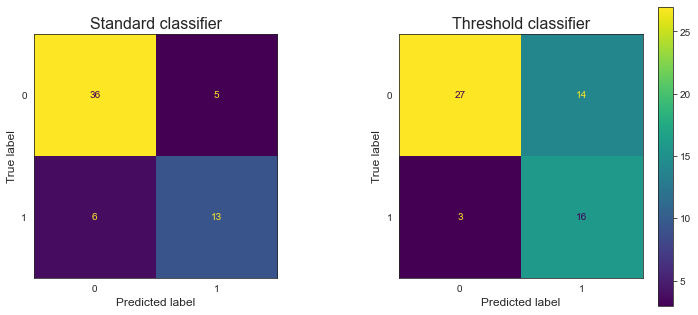

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Standard classifier',fontsize = 16)
ax2.set_title('Threshold classifier',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax1)
m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf2, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

The pattern is clearly different: as we expect there are many more false positives, however the true positive increases.

In [57]:
print('TEST PERFORMANCES : STANDARD CLASSIFIER')
print(classification_report(y_test, clf1.predict(X_test)))
print('\nTEST PERFORMANCES : THRESHOLD CLASSIFIER')
print(classification_report(y_test, clf2.predict(X_test)))

TEST PERFORMANCES : STANDARD CLASSIFIER
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        41
           1       0.72      0.68      0.70        19

    accuracy                           0.82        60
   macro avg       0.79      0.78      0.79        60
weighted avg       0.81      0.82      0.82        60


TEST PERFORMANCES : THRESHOLD CLASSIFIER
              precision    recall  f1-score   support

           0       0.90      0.66      0.76        41
           1       0.53      0.84      0.65        19

    accuracy                           0.72        60
   macro avg       0.72      0.75      0.71        60
weighted avg       0.78      0.72      0.73        60



With the classification reports, the benefits of the new models are even more clear. The probability threshold leads to an increase in the recall of *death patients* and an increase in the precision of the *survived patients*. That is, it predicts as *survived* only when it is highly confident in terms of probability: it requires at least a $70 \%$ of confidence that the patient can survive. However, the addition of the threshold leads to a decrease to $0.65$ in terms of (test) *F1-score*.

## Linear Discriminant Analysis (LDA)
The **LDA** classifier can be seen as variant of the *Naive Bayesian Classifier*. In fact, they share the use of the *Bayes Theorem* for computing the posterior probability, and they use the same decision rule in classification. While, they differ in the assumption, specifically *LDA* assume that the features are drawn from a multivariate normal distribution with class-specific vectors. Hence, the attributes have still a normal distribution but they not independent in genaral. Formally, the distribution of the input vector $x$ given the class label $y$ is given by
\begin{equation}
\mathbb{P}\left(X = x | Y = y\right) = \frac{1}{ \left(2\pi\right)^{\frac{n}{2}} |\Sigma|^{\frac{1}{2}} } \exp{-\frac{1}{2}\left(x - \mu_y\right)'\Sigma^{-1}\left(x - \mu_y\right)},
\end{equation}
where $\mu_y$ is the class-specific mean vector and $\Sigma$ is the covariance matrix. These quantities will be estimated during training, with standard statistical procedures. 

Then, we can plug this formula into the Bayes rule and obtaining the distribution of $y$ conditionally on $x$ and classify according to the rule 
\begin{equation}
C(x)= arg\max_{y \in \mathcal{C}} \mathbb{P}\left(Y = y|X = x\right) = arg\max_{y \in \mathcal{C}} \mathbb{P}\left(Y = y\right)  \mathbb{P}\left(X = x | Y = y\right).
\end{equation}
Equivalently, we can reason in terms of logarithm of such distribution, obtaining the so called **discriminant functions**
\begin{equation}
\delta_y(x) = \log(\pi_y) - \frac{1}{2} \left(x - \mu_y\right)'\Sigma^{-1}\left(x - \mu_y\right),
\end{equation}
where $\pi_y = \mathbb{P}\left(Y = y\right)$ is estimated with the training proportion of the class labels. 

During training, we estimate the class-specific mean vectors and the class-independent covariance matrix through standard statistical estimates. Then, given any input vector, we can classify assigning the label with the highest discriminant function. 

The model has not hyperparameter, so can directly fit it over the whole training set. However, there is an important difference between the previous models: since we should assume a gaussian distribution for the input data we can consider only the numerical features (they are the first $6$ of the dataset). Obviously, we could run the model with the whole dataset, however, as a consequence, we may lead to misleading results or an unstable classifier. So, we consider only numerical features.

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
print('Training LDA classifier \n')
baseline_estimator_evaluation(LinearDiscriminantAnalysis(), X_train_resampled[:,:6], y_train_resampled)
clf1= LinearDiscriminantAnalysis().fit(X_train_resampled[:,:6], y_train_resampled)
classifiers['LDA'] = copy.deepcopy(clf1)

Training LDA classifier 

10 fold CV F1-score : 0.7359


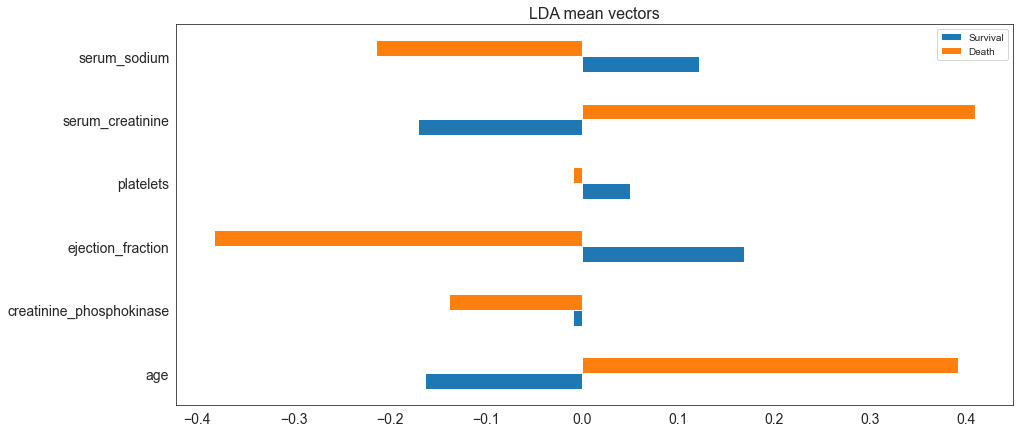

In [59]:
mu = clf1.means_

fig, ax = plt.subplots(1, figsize=(15,7))
df = pd.DataFrame({'Survival': mu[0,:], 'Death': mu[1,:]}, index = numeric_columns)
df.plot.barh(ax=ax,fontsize = 14)
ax.set_title('LDA mean vectors', fontsize = 16)
plt.show()

Interestingly, we can see what are the estimated mean vectors and comparing them. We can appreciate that there are neat differences between each component of the vector. For that reason, we expect that the models will share good classification capability.   

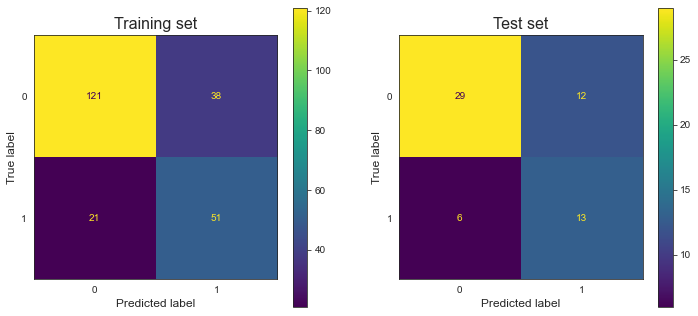

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train[:,:6], y_train, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test[:,:6], y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

In [61]:
print('TRAINING PERFORMANCES')
print(classification_report(y_train, clf1.predict(X_train[:,:6])))
print('\nTEST PERFORMANCES')
print(classification_report(y_test, clf1.predict(X_test[:,:6])))

TRAINING PERFORMANCES
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       159
           1       0.57      0.71      0.63        72

    accuracy                           0.74       231
   macro avg       0.71      0.73      0.72       231
weighted avg       0.77      0.74      0.75       231


TEST PERFORMANCES
              precision    recall  f1-score   support

           0       0.83      0.71      0.76        41
           1       0.52      0.68      0.59        19

    accuracy                           0.70        60
   macro avg       0.67      0.70      0.68        60
weighted avg       0.73      0.70      0.71        60



The results show similar performances in training and test. It shows a good recall capacity but it fails in precision. Moreover, it behaves worst than *Naive Bayes* (remember that the *Naive Bayes* obtain a $F1 score$ of 0.7, for class $1$): the addition of correlations between features is not enough for compensating the lack of the binary variables. 

As in the previous model, we can obtain the probability threshold for classification via cross-validation.

In [62]:
_, best_thrs = find_threshold_cv(lambda  : LinearDiscriminantAnalysis() , X_train_resampled[:,:6],
                                 np.array(y_train_resampled), SEED_HP_TUNING_THRESHOLD)
   
clf2 = probability_binary_classifier(clf1, best_thrs)

Best threshold : 0.4, 10-fold CV F1 score : 0.7503


The best threshold turns out to be $0.40$, that is we predict as $1$ whenever we have a probability of $40\%$ of risk of death for the patient.

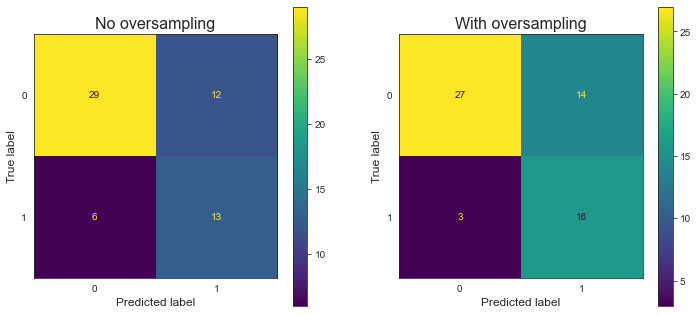

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('No oversampling',fontsize = 16)
ax2.set_title('With oversampling',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_test[:,:6], y_test, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf2, X_test[:,:6], y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

In [64]:
print('TEST PERFORMANCES : STANDARD CLASSIFIER')
print(classification_report(y_test, clf1.predict(X_test[:,:6])))
print('\nTEST PERFORMANCES : THRESHOLD CLASSIFIER')
print(classification_report(y_test, clf2.predict(X_test[:,:6])))

TEST PERFORMANCES : STANDARD CLASSIFIER
              precision    recall  f1-score   support

           0       0.83      0.71      0.76        41
           1       0.52      0.68      0.59        19

    accuracy                           0.70        60
   macro avg       0.67      0.70      0.68        60
weighted avg       0.73      0.70      0.71        60


TEST PERFORMANCES : THRESHOLD CLASSIFIER
              precision    recall  f1-score   support

           0       0.90      0.66      0.76        41
           1       0.53      0.84      0.65        19

    accuracy                           0.72        60
   macro avg       0.72      0.75      0.71        60
weighted avg       0.78      0.72      0.73        60



Interestingly, the threshold classifier lead to the very same results of the case with *Naive Bayes*. Moreover, it leads to an increase from $0.59$ to $0.65$ in terms of *F1 score*.

## Quadratic Discriminant Analysis (QDA)
The **QDA classifier** is an extension of *LDA*, where we consider also class-specific covariance matrices. That is, we assume that the probability distribution of the input features conditionally on the class label $y$ is a gaussian multivariate distribution with mean vector $\mu_y$ and covariance matrix $\Sigma_y$. Formally, the distribution of the input vector $x$ given the class label $y$ is given by
\begin{equation}
\mathbb{P}\left(X = x | Y = y\right) = \frac{1}{ \left(2\pi\right)^{\frac{n}{2}} |\Sigma_y|^{\frac{1}{2}} } \exp{-\frac{1}{2}\left(x - \mu_y\right)'\Sigma_y^{-1}\left(x - \mu_y\right)}. 
\end{equation}
Then, the **discriminant functions** become,
\begin{equation}
\delta_y(x) = \log(\pi_y) - \frac{1}{2}log\left(|\Sigma_y|\right) - \frac{1}{2} \left(x - \mu_y\right)'\Sigma_y^{-1}\left(x - \mu_y\right),
\end{equation}
Finally, as before, for any input vector, we classify according to the class label with the highest discriminant function. 

As in *LDA* there are no hyperparameters.

In [65]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
print('Training QDA classifier \n')
baseline_estimator_evaluation(QuadraticDiscriminantAnalysis(), X_train_resampled[:,:6], y_train_resampled)
clf1= QuadraticDiscriminantAnalysis().fit(X_train_resampled[:,:6], y_train_resampled)
classifiers['QDA'] = copy.deepcopy(clf1)

Training QDA classifier 

10 fold CV F1-score : 0.7582


We get a slightly better cross-validation performance measure.

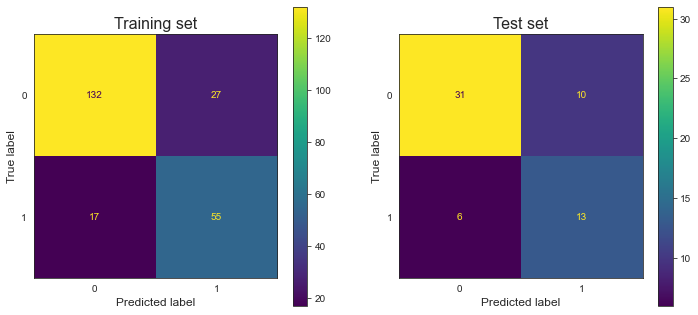

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train[:,:6], y_train, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test[:,:6], y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

In [67]:
print('TRAINING PERFORMANCES')
print(classification_report(y_train, clf1.predict(X_train[:,:6])))
print('\nTEST PERFORMANCES')
print(classification_report(y_test, clf1.predict(X_test[:,:6])))

TRAINING PERFORMANCES
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       159
           1       0.67      0.76      0.71        72

    accuracy                           0.81       231
   macro avg       0.78      0.80      0.79       231
weighted avg       0.82      0.81      0.81       231


TEST PERFORMANCES
              precision    recall  f1-score   support

           0       0.84      0.76      0.79        41
           1       0.57      0.68      0.62        19

    accuracy                           0.73        60
   macro avg       0.70      0.72      0.71        60
weighted avg       0.75      0.73      0.74        60



Unexpectedly, we see lower test performances than *LDA* (with *LDA* we had $0.65$ of *F1 score*). This behavior could be address in two aspects:
- the features do not share different correlation patterns as a function of the class label;
- there was not enough data for correctly estimating the two covariance matrices, making the decision boundary more unstable. 

As before, we can obtain the probability threshold for classification via cross-validation.

In [68]:
_, best_thrs = find_threshold_cv(lambda  : QuadraticDiscriminantAnalysis() , X_train_resampled[:,:6],
                                 np.array(y_train_resampled), SEED_HP_TUNING_THRESHOLD)

    
clf2 = probability_binary_classifier(clf1, best_thrs)

Best threshold : 0.475, 10-fold CV F1 score : 0.772


We can see a threshold higher than before, for that reason we aspect that the threshold classifier is quite similar to the standard one. 

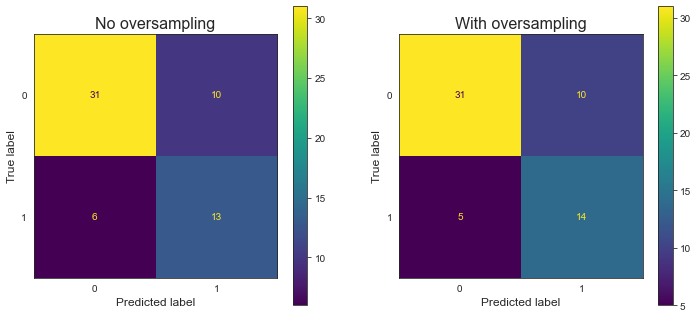

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('No oversampling',fontsize = 16)
ax2.set_title('With oversampling',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_test[:,:6], y_test, ax = ax1)
# m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf2, X_test[:,:6], y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()

In [70]:
print('TEST PERFORMANCES : STANDARD CLASSIFIER')
print(classification_report(y_test, clf1.predict(X_test[:,:6])))
print('\nTEST PERFORMANCES : THRESHOLD CLASSIFIER')
print(classification_report(y_test, clf2.predict(X_test[:,:6])))

TEST PERFORMANCES : STANDARD CLASSIFIER
              precision    recall  f1-score   support

           0       0.84      0.76      0.79        41
           1       0.57      0.68      0.62        19

    accuracy                           0.73        60
   macro avg       0.70      0.72      0.71        60
weighted avg       0.75      0.73      0.74        60


TEST PERFORMANCES : THRESHOLD CLASSIFIER
              precision    recall  f1-score   support

           0       0.86      0.76      0.81        41
           1       0.58      0.74      0.65        19

    accuracy                           0.75        60
   macro avg       0.72      0.75      0.73        60
weighted avg       0.77      0.75      0.76        60



## Support Vector Machines (SVM)
The idea of **Support Vector Machines** is: given that you have points in a multi-dimensional space, you want to find a separating hyperplane that can distinguish between points of different classes. Specifically, points of the same class should be on the same side of the hyperplane. Moreover, among the possible hyperplanes, you want to find the one that best separates the points. Precisely, you want to maximize the *margin*, that is distance between the hyperplane and the closest points on each side. This procedure defines a particular kind of *SVM*, the **Linear SVM**. Now, the crucial question is : Does such a hyperplane exists? Unfortunately, often the answer is no, so there have been proposed a lot of techniques for overcoming the problem:
- allow some misclassification, that is allowing that same points can violate the margin within a controlled distance;
- introduce non-linear decision boundaries, through non-linear transformation;

The first strategy allows to obtain a more robust classifier, and it is tackled by slightly changing the optimization problem that defines the model. While the second bullet is more subtle, theoretically it requires finding a non linear mapping from the original feature space $\mathcal{X}$ to another one which we denote as $\mathcal{F}$,
\begin{equation}
    \phi : \mathcal{X} \longrightarrow \mathcal{F},
\end{equation}
additionally, we require that $\mathcal{F}$ is a, possibly infinite-dimensional, Hilbert space. Then, the idea is that the mapped points might be linearly separable (i.e. separable with a hyperplane) in the destination space, or at least better separated than in the original space. As a result, if we have found such a hyperplane in the destination space and if look back at the decision boundaries obtained in the original space we can understand that they are not linear anymore. 

Then, exploiting the presented tecniques, the general problem that define *SVM* can be written as follow
\begin{align}
&\min_{w,b,\zeta}  \frac{1}{2}||w||^2_2 + C\sum_{i=1}^m \zeta_i \\
& s.t. \quad y_i\left(b + <w,\phi(x_i)>\right) \geq 1 - \zeta_i, \quad \forall i = 1 ... m, \\
& \quad \quad \quad \zeta_i \geq 0 \quad \forall i = 1, ..., m;
\end{align}
where $\phi(\cdot)$ is the non-linear mapping, $b\in\mathbb{R}$ and $w\in\mathcal{F}$ are the coeffiecients that identify the hyperplane in the destination space $\mathcal{F}$, $(x_i,y_i)$ are the input data (the label $y_i$ is encoded in the set $\{-1,1\}$ for convenience). While, $\zeta_i$ is the margin violation for the sample $(x_i,y_i)$, and they determinate by the constraints. In fact, the quantity $y_i\left(b + <w,\phi(x_i)>\right)$ can be seen as the distance from the hyperplane individuated by $(b,w)$ and the sample $(x_i,y_i)$. The second term of the objective function penalize the margin violation, and the hyperparameter *C* controls the stregth of the penalization. Finally, can be proved that the margin is the inverse of the quantity $||w||_2$, so the first term of the objective aim in maximizing the margin. 

Now, the question is: what mapping $\phi(\cdot)$ should we consider? The answer is that it is very difficult to define
mappings that work well in classification. Moreover, even if we know the mapping the curse of dimensionality can strike arising numerical issues. However, we can derive a strategy that exploits the benefit of the non-linear mapping with using the mapping, but only by changing how we compute inner product in the feature space $\mathcal{X}$, for doing that we exploit the so-called **kernel trick**. 

Given a mapping $\phi(\cdot)$ from some feature space $\mathcal{X}$ to some Hilbert space $\mathcal{F}$, we define
the *kernel function* as follow
\begin{equation}
    K\left(x,x'\right) = < \phi(x),\phi(x')>_{\mathcal{F}}.
\end{equation}

The idea of the *kernel trick* is defining functions that are kernels but without explicitly declaring the mapping.
This is possible thanks to the *Mercer Theorem*, which states necessary and sufficient conditions for being a kernel function. In that way, if we determinate a function that satisfies Mercer's conditions, the function is a kernel and there exist a mapping $\phi(\cdot)$ and a destination Hilbert space $\mathcal{F}$, in which the kernel function represents the inner product. 

Given that we have a kernel $K\left(\cdot, \cdot\right)$, the final step is considering the dual formulation of the *SVM problem*, in fact this last requires only the knownledge of the kernel function, without the use of the mapping. The dual formulation is 
\begin{align}
&\min_{\alpha}  \frac{1}{2}\alpha' Q \alpha - \mathbb{1}'\alpha\\
& s.t. \quad \alpha'y = 0\\
& \quad \quad 0\leq \alpha_i \leq C \quad \forall i = 1, ..., m;
\end{align}
where $\alpha$ is the dual variable and $Q\in\mathbb{R}^{m\times m}$ is positive semidefinite matrix such that $Q_{ij}=y_iy_jK\left(x_i, x_j\right)$.

The research put a lot of effort in devoloping kernels that satisfy Mercer Theorem, in this works we consider:
- the linear kernel : $K\left(x, x'\right) = <x,x'>$, which correspond to the identity mapping.
- polynomial kernel : $K\left(x, x'\right) = \left(\gamma <x,x'> + r\right)^d$, where $d$, $r$ and $\gamma$ are hyperparameter;
- gaussian kernel : $K\left(x, x'\right) = \exp{\left(\gamma ||x-x'||_2^2\right)}$, where $\gamma$ is an hyperparameter;
- sigmoid kernel : $K\left(x, x'\right) = \tanh\left(\gamma <x,x'> + r\right)$, where $d$, $r$ and $\gamma$ are hyperparameter.

Finally, given an input vector $x$ we classify accordingly to the sign of the following decision function,
\begin{equation}
    f(x) = \sum_{i \in SV} \alpha_i y_i K\left(x_i,x\right) + b.
\end{equation}
where *SV* is the set of **support vectors**: the set of training points there rely at the boundary or inside the margin.

In the following we experienced the *SVM classifier* applied to our dataset, the kernel with the corresponding parameters, as well as the parameter $C$ are determined through cross-validation, then the model with the best configuration of hyperparameter is fitted on the whole training set.

In [71]:
from sklearn.svm import SVC
print('Training & HP tuning of SVM')
grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
       'C': np.linspace(0.2,4,21),
        'degree': [3,4,5],
       'gamma': ['scale', 'auto'],
       'coef0' : np.linspace(0,4,21)}
clf1 = grid_search_cv(SVC(random_state = SEED_MODEL_STATE), X_train_resampled, y_train_resampled, grid, f1_score)
classifiers['SVM'] = copy.deepcopy(clf1)

Training & HP tuning of SVM
Best configuration : {'C': 3.0500000000000003, 'coef0': 0.2, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
10 fold CV F1-score : 0.8231


The best configuration identify 
- a coefficient *C* of around $3.05$,
- the kernel function
\begin{equation}
K\left(x, x'\right) = \left(\frac{<x,x'>}{n \sigma^2} + 0.2\right)^3,
\end{equation}
where $n$ is the number of feature and $\sigma^2$ is the overall variance.

As we expect gird search selects a kernel that allows a non-linear decision boundary. Next, we evaluate the best SVM model both in training and test set.

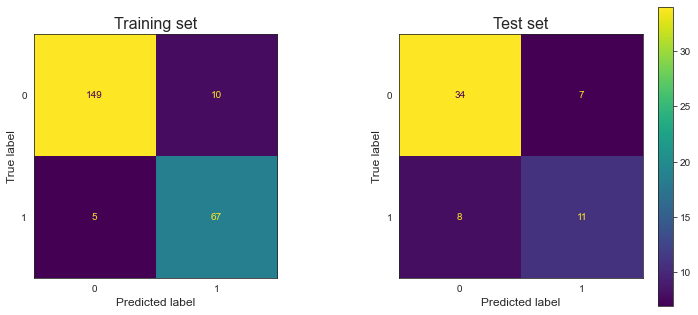

In [72]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5.5])
ax1.set_title('Training set',fontsize = 16)
ax2.set_title('Test set',fontsize = 16)
ax1.set_xlabel('Predicted label', fontsize = 12)
ax1.set_ylabel('True label', fontsize = 12)
m1 = plot_confusion_matrix(clf1, X_train, y_train, ax = ax1)
m1.im_.colorbar.remove()
m2 = plot_confusion_matrix(clf1, X_test, y_test, ax = ax2)
ax2.set_xlabel('Predicted label', fontsize = 12)
ax2.set_ylabel('True label', fontsize = 12)
plt.show()


In [73]:
print('TRAINING PERFORMANCES')
print(classification_report(y_train, clf1.predict(X_train)))
print('\nTEST PERFORMANCES')
print(classification_report(y_test, clf1.predict(X_test)))

TRAINING PERFORMANCES
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       159
           1       0.87      0.93      0.90        72

    accuracy                           0.94       231
   macro avg       0.92      0.93      0.93       231
weighted avg       0.94      0.94      0.94       231


TEST PERFORMANCES
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        41
           1       0.61      0.58      0.59        19

    accuracy                           0.75        60
   macro avg       0.71      0.70      0.71        60
weighted avg       0.75      0.75      0.75        60



We can see an important reduction in performances from training to test set, especially regarding class $1$. While for class $0$ the decrease in performances is less stressed, reaching a test *F1 score* of $0.82$.

## Models evaluation 
Finally, we can compare the obtained classifiers in terms of test performances. Since we have kept the test set unsullied it should properly represent the real data distribution, for that reason, we can fairly evaluate the goodness of our classifiers in terms of classification metrics obtained from this set. Specifically, we report all the binary classification metrics but we rank the classifiers in terms on the *F1 score*, the higher the better. 

In [74]:
# print("\t Classifier \t| F1 score")
l0 = [] # accuracy
l1 = []
l2 = []
l3 = []
l4 = []
ls = []
from sklearn.metrics import precision_score, recall_score
for name, clf in classifiers.items():
    ls.append((name,clf))
    l1.append(name)
    if name == 'LDA' or name == 'QDA':
        l2.append(f1_score(y_test, clf.predict(X_test[:,:6])))
        l3.append(precision_score(y_test, clf.predict(X_test[:,:6])))
        l4.append(recall_score(y_test, clf.predict(X_test[:,:6])))
        l0.append(accuracy_score(y_test, clf.predict(X_test[:,:6])))
    else:
        l2.append(f1_score(y_test, clf.predict(X_test)))
        l3.append(precision_score(y_test, clf.predict(X_test)))
        l4.append(recall_score(y_test, clf.predict(X_test)))
        l0.append(accuracy_score(y_test, clf.predict(X_test)))
    # print(f"\t {name}\t\t|{f1_score(y_test, clf.predict(X_test))}")


d_tmp = {'Classifier': l1,'Accuracy': np.round(l0,4), 'Precision' : np.round(l3, 4),'Recall' : np.round(l4, 4),'F1 score' : np.round(l2, 4)}

d = pd.DataFrame(d_tmp)
d.sort_values('F1 score', inplace = True, ascending = False, ignore_index = True)
best_classifiers = set(d.loc[:3,'Classifier'])
d.head(len(ls))

,Classifier,Accuracy,Precision,Recall,F1 score
0,Naive Bayes,0.8167,0.7222,0.6842,0.7027
1,"K-NN, k = 3",0.7833,0.6250,0.7895,0.6977
2,Random Forest,0.7667,0.6190,0.6842,0.6500
3,QDA,0.7333,0.5652,0.6842,0.6190
4,Decision Tree,0.7500,0.6000,0.6316,0.6154
5,SVM,0.7500,0.6111,0.5789,0.5946
6,LDA,0.7000,0.5200,0.6842,0.5909
7,K-NN,0.7000,0.5217,0.6316,0.5714
8,Logistic Regression,0.6667,0.4800,0.6316,0.5455


Another important evaluation metric is **ROC Curve** (Receiver Operating Characteristic Curve)and it is even more complete than *F1 score*. It plots the *false positive rate* (x-axis) versus the *true positive rate* (y-axis) for a number of candidate probability thresholds from $0$ to $1$, where,
\begin{align}
\text{false positive rate (fpr)} & = \frac{FP}{FP+TN}, \\ 
\text{true positive rate (tpr)} & = \frac{TP}{TP+FN}. \\ 
\end{align}
The *tpr* is nothing more than the *Recall*, while *fpr* quantifies the rate of positive misclassifications. A model with perfect skills draws a curve that travels from the bottom left of the plot, then to the top left, and finally to the top right corner. The area under the curve drawn by this perfect model is equal to $1$. In general the area under the *ROC curve* is called **AUC** and it is a global performance measure, the higher the better knowing that $1$ is the upper bound. 

For clearness of the plot we report only, the first $4$ classifiers ranked according to the *F1-score*.

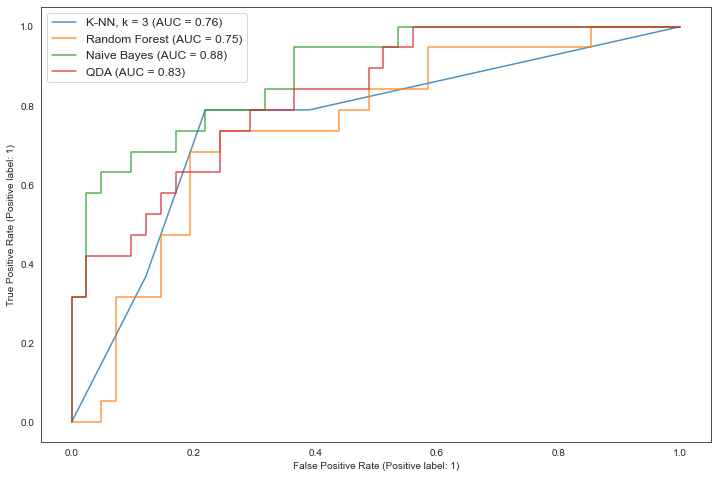

In [75]:
fig, ax = plt.subplots(figsize = [12,8])
i = 0
for name, clf in classifiers.items():
    if i == 0:
        if name in best_classifiers:
            if name == 'LDA' or name == 'QDA':
                plot_roc_curve(clf, X_test[:,:6], y_test, ax = ax, name = name)
            else:
                plot_roc_curve(clf, X_test, y_test, ax = ax, name = name)
    else:
        if name in best_classifiers:
            if name == 'LDA' or name == 'QDA':
                plot_roc_curve(clf, X_test[:,:6], y_test, ax = ax, name = name, alpha = 0.8)
            else:
                plot_roc_curve(clf, X_test, y_test, ax = ax, name = name, alpha = 0.8)
    i +=1
    
ax.legend(fontsize =12)
plt.show()          

From the plot, we can see that the *Naive Bayes* totally outperforms the other classifiers, reaching an extremely high *AUC* of $0.88$. Unexpectedly, the *QDA* goes up to the second position according to *AUC*. 

## Conclusion
We have experimented with a lot of classification algorithms on this dataset, each of these shows pros and cons. Based on the experiments we can say that the *Naive Bayesian Classifier* is the best for this kind of data. Moreover, its classification strategy based on probability gives a lot of flexibility to the model. A possible application of the model can be the following. Imagine that we are in a context where the algorithm helps the cardiological department of a hospital to discriminate which of the many patients require more careful medical analysis or more specific treatments. We could then exploit the classification strategy in terms of probability thresholds, setting the threshold as a function of the department capacity.  The department capacity can be expressed for example in terms of the availability of the medical department's staff or the number of free hospital beds. Then, we can lower the threshold whenever the department has a high capacity and as a result, we predict more often the risk for the patients maximizing the chance of saving their life. On the other hand, whenever the hospital is already busy we can raise up threshold and as a result, the number of prediction of risk decreases but the prediction identify patients that really require treatments with more confidence. 